In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter

from collections import Counter
from astropy import constants as const
import warnings
warnings.filterwarnings("ignore")
import math
import os
import time

import seaborn as sns
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics


import pickle
import scipy
from scipy.stats import norm
from scipy.stats import skewnorm
from scipy.stats import multivariate_normal
from scipy.stats import bootstrap
from scipy import interpolate
from scipy.optimize import curve_fit

rocky = "Sienna"
water = "lightskyblue"
puffy = "#eddec5"
earth = "0.4"
h20   = "#9fb8bf"

colors = ['blue', 'yellow', 'red']
custom_cmap = ListedColormap(colors)

colors = ['0.5', rocky, puffy]
custom_cmap2 = ListedColormap(colors)

colors = [ rocky,puffy,water,]
custom_cmap3 = ListedColormap(colors)

colors = ['red', 'yellow']
custom_cmap2pop = ListedColormap(colors)


## Import data and save lists

In [2]:
dataLI = pd.read_csv("../Thesis/Data/STPM_improved_210721.csv", delimiter=",")
dataEA = pd.read_csv("../Thesis/Data/composite_sample_8_may_2024.csv",delimiter=",")
#dataEA = pd.read_csv("../Thesis/Data/2024sample_composite.csv",delimiter=",")
planet_name_LI        = list(dataLI["Star"]+" "+dataLI["Planet"])
dataLI["planet_name"] = planet_name_LI

earth_Mass = const.M_earth.value*1000 #g
earth_Radius = const.R_earth.value*100
earth_Volume = 4/3 * math.pi * earth_Radius**3
earth_density = earth_Mass / earth_Volume
    
earth_like_rocky  = pd.read_csv("../Thesis/Mass_Radius_Curves/Earth-like Rocky (32.5% Fe+67.5% MgSiO3).txt",delimiter = "\t")
H20_50_500K       = pd.read_csv("../Thesis/Mass_Radius_Curves/50% H2O (50% Earth-like rocky core + 50% H2O layer by mass)_500 K_1mili-bar surface temprture.txt",delimiter = "\t")

earth_Mass = const.M_earth.value*1000 #g
earth_Radius = const.R_earth.value*100
earth_Volume = 4/3 * math.pi * earth_Radius**3
earth_density = earth_Mass / earth_Volume

In [3]:
# Luque Impoved
planet_id_LI         = dataLI.ID
star_name_LI         = dataLI.Star
planet_letter_LI     = dataLI.Planet

radius_LI            = dataLI.R_Rterra             # [Earth Radius]
radius_unc_up_LI     = dataLI.euR_Rterra           # [Earth Radius] Upper Unc.
radius_unc_low_LI    = dataLI.edR_Rterra           # [Earth Radius] Lower Unc.

mass_LI              = dataLI.M_Mterra             # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]
mass_unc_up_LI       = dataLI.euM_Mterra           # [Earth Mass] Upper Unc.
mass_unc_low_LI      = dataLI.edM_Mterra           # [Earth Mass] Lower Unc.

density_LI           = dataLI[dataLI.columns[32]]  # [g/cm**3]
density_unc_up_LI    = dataLI[dataLI.columns[33]]  # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_LI   = dataLI[dataLI.columns[34]]  # [g/cm**3] Planet Density Lower Unc
star_eff_LI          = dataLI.Teff_K
pl_eq_LI             = dataLI.Teq_K                # [K] Equilibrium Temperature

# Exoplanet Archive
planet_name_EA       = dataEA.pl_name
planet_id_EA         = list(range(0,len(planet_name_EA)))

radius_EA            = dataEA.pl_rade             # [Earth Radius]
period_EA            = dataEA.pl_orbper           # [days]
radius_unc_up_EA     = dataEA.pl_radeerr1         # [Earth Radius] Upper Unc.
radius_unc_low_EA    = dataEA.pl_radeerr2         # [Earth Radius] Lower Unc.
mass_EA              = dataEA.pl_bmasse           # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]

mass_unc_up_EA       = dataEA.pl_bmasseerr1       # [Earth Mass] Upper Unc.
mass_unc_low_EA      = dataEA.pl_bmasseerr2       # [Earth Mass] Lower Unc.

density_EA           = dataEA.pl_dens             # [g/cm**3]
density_unc_up_EA    = dataEA.pl_denserr1         # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_EA   = dataEA.pl_denserr2         # [g/cm**3] Planet Density Lower Unc. 
st_spectype_EA       = dataEA.st_spectype         # Spectral type of star
pl_eq_EA             = dataEA.pl_eqt              # [K] Equilibrium Temperature
st_eff_EA            = dataEA.st_teff             # Star effective temprature
st_eff_up_EA         = dataEA.st_tefferr1         # Star upper err effective temprature
st_eff_low_EA        = dataEA.st_tefferr2         # Star lower err effective temprature
disc_year_EA         = dataEA.disc_year

In [4]:
planets = ["K2-146 b",'TRAPPIST-1 h', 'TRAPPIST-1 d', 'TRAPPIST-1 e', 'TRAPPIST-1 f', 'TRAPPIST-1 g', 'TRAPPIST-1 c', 'TRAPPIST-1 b', 'GJ 1132 b', 'TOI-270 b', 'GJ 3053 c', 'GJ 1252 b', 'GJ 357 b', 'LTT 3780 b', 'LHS 1478 b', 'GJ 486 b', 'GJ 3473 b', 'CD-60 8051 b', 'L 98-59 c', 'L 98-59 d', 'GJ 3053 b', 'TOI-270 d', 'TOI-776 b', 'TOI-1634 b', 'TOI-1685 b', 'TOI-1235 b', 'K2-146 c', 'LTT 3780 c', 'TOI-270 c', 'K2-18 b', 'TOI-269 b', 'GJ 1214 b', 'K2-25 b', 'TOI-1231 b']
planet1      = []; planet_i1       = []; planet_eq1   = []
disc_year1   = []; st_eff1         = []; st_type1     = []
radius1      = []; radius_up1      = []; radius_low1  = []
mass1        = []; mass_up1        = []; mass_low1    = []
density1     = []; density_up1     = []; density_low1 = []

for i in range(0,len(planet_name_LI)):
    if planet_name_LI[i] in planets:
        planet1.append(planet_name_LI[i]); planet_eq1.append(pl_eq_LI[i]);          st_eff1.append(star_eff_LI[i]);
        radius1.append(radius_LI[i]);      radius_up1.append(radius_unc_up_LI[i]);  radius_low1.append(radius_unc_low_LI[i]);
        mass1.append(mass_LI[i]);          mass_up1.append(mass_unc_up_LI[i]);      mass_low1.append(mass_unc_low_LI[i]);
        density1.append(density_LI[i]);    density_up1.append(density_unc_up_LI[i]); density_low1.append(density_unc_low_LI[i]);

In [5]:
planet_EA_unique = list(set(planet_name_EA))
other_names = ["LHS 1140 b",'LHS 1140 c' ,'L 168-9 b', 'L 168-9 c', "GJ 3053 b","GJ 3053 c"]

radius_4_crit     = []; mass_err_crit     = []
radius_err_crit   = []; stellar_type_crit = []
st_eff_crit       = []; density_crit      = []

for i in range(0,len(planet_name_EA)):
    if planet_name_EA[i] not in planet_name_LI and planet_name_EA[i] not in other_names and planet_name_EA[i]:
        if planet_name_EA[i] not in radius_4_crit and radius_EA[i]<4:
            radius_4_crit.append(planet_name_EA[i])
        if planet_name_EA[i] not in mass_err_crit and ((mass_unc_up_EA[i] + mass_unc_up_EA[i])*0.5) / mass_EA[i] < 0.25:
            mass_err_crit.append(planet_name_EA[i])    
        if planet_name_EA[i] not in radius_err_crit and ((radius_unc_up_EA[i] + radius_unc_up_EA[i])*0.5) / radius_EA[i] < 0.08:
            radius_err_crit.append(planet_name_EA[i])   
        if planet_name_EA[i] not in stellar_type_crit and "M" in str(st_spectype_EA[i]):
            stellar_type_crit.append(planet_name_EA[i])   
        if planet_name_EA[i] not in density_crit and True != math.isnan(density_unc_up_EA[i]):
            density_crit.append(planet_name_EA[i])   

list1 = radius_4_crit;   list2 = mass_err_crit; 
list3 = radius_err_crit; list4 = stellar_type_crit; 
list5 = density_crit

common_elements = np.sort(list(set(list1) & set(list2) & set(list3) & set(list4) & set(list5)))

planet2      = []; planet_i2       = []; planet_eq2   = []
disc_year2   = []; st_eff2         = []
radius2      = []; radius_up2      = []; radius_low2  = []
mass2        = []; mass_up2        = []; mass_low2    = []
density2     = []; density_up2     = []; density_low2 = []

for j in range(0,len(common_elements)):
    target_string = str(common_elements[j])
    indexs = [index for index, value in enumerate(planet_name_EA) if value == target_string]
    i = indexs[0]
    if st_eff_EA[i] < 4000:
        st_eff2.append(st_eff_EA[i])
        planet_eq2.append(pl_eq_EA[i]); planet2.append(planet_name_EA[i]); disc_year2.append(disc_year_EA[i])
        radius2.append(dataEA.pl_rade[i]); radius_up2.append(dataEA.pl_radeerr1[i]); radius_low2.append(dataEA.pl_radeerr2[i])
        density2.append(dataEA.pl_dens[i]); density_up2.append(dataEA.pl_denserr1[i]); density_low2.append(dataEA.pl_denserr2[i])
        mass2.append(dataEA.pl_bmasse[i]); mass_up2.append(dataEA.pl_bmasseerr1[i]);  mass_low2.append(dataEA.pl_bmasseerr2[i])

In [6]:
earth_like_rocky_mass_g        = earth_Mass*np.array(earth_like_rocky["Mass"])
earth_like_rocky_radius_cm     = earth_Radius*np.array(earth_like_rocky["Radius"])
earth_like_rocky_density_g_cm3 = (earth_like_rocky_mass_g) / ((4/3)*(np.pi)*(np.power(earth_like_rocky_radius_cm,3))   ) 

H20_50_500K_mass_g        = earth_Mass*np.array(H20_50_500K["Mass"])
H20_50_500K_radius_cm     = earth_Radius*np.array(H20_50_500K["Radius"])
H20_50_500K_density_g_cm3 = (H20_50_500K_mass_g) / ((4/3)*(np.pi)*(np.power(H20_50_500K_radius_cm,3))   ) 


def rocky_density(mass):
    x_points  = earth_like_rocky["Mass"]
    y_points  = earth_like_rocky_density_g_cm3
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

def rocky_density2(mass):
    x_points  = earth_like_rocky["Mass"]
    y_points  = earth_like_rocky_density_g_cm3/earth_like_rocky_density_g_cm3
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

def h20model_density(mass):
    x_points  = H20_50_500K["Mass"]
    y_points  = H20_50_500K_density_g_cm3/rocky_density(H20_50_500K["Mass"])
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

mass    = np.concatenate((mass1, mass2));       mass_up     = np.concatenate((mass_up1, mass_up2));       mass_low     = np.concatenate((mass_low1, mass_low2));
radius  = np.concatenate((radius1, radius2));   radius_up   = np.concatenate((radius_up1, radius_up2));   radius_low   = np.concatenate((radius_low1, radius_low2));
density = np.concatenate((np.array(density1) / rocky_density(mass1), np.array(density2)/ rocky_density(mass2))); density_up  = np.concatenate((np.array(density_up1)/ rocky_density(mass1), np.array(density_up2)/ rocky_density(mass2))); density_low  = np.concatenate((np.array(density_low1)/ rocky_density(mass1),np.array(density_low2)/ rocky_density(mass2)));
density_nonnorm = np.concatenate((np.array(density1), np.array(density2))); density_upnonnorm  = np.concatenate((np.array(density_up1), np.array(density_up2))); density_lownonnorm  = np.concatenate((np.array(density_low1),np.array(density_low2)));

planet_temp = np.concatenate((planet_eq1, planet_eq2));
planet_name = np.concatenate((planet1,    planet2));
star_eff    = np.concatenate((st_eff1,    st_eff2));
disc_year   = np.concatenate((disc_year1,    disc_year2));

mass_err    = [np.abs(mass_low),mass_up]
radius_err  = [np.abs(radius_low),radius_up]
density_err = [np.abs(density_low),density_up]

density_errnonnorm = [np.abs(density_lownonnorm),density_upnonnorm]

mass10      = np.log10(mass)
mass10_up   = np.log10(mass + mass_up) - np.log10(mass)
mass10_low  = np.log10(mass + np.abs(mass_low)) - np.log10(mass)
mass10_err  = [mass10_low,mass10_up]

mass_err1    = [np.abs(mass_low1),mass_up1]
radius_err1  = [np.abs(radius_low1),radius_up1]

density1_norm = np.array(density1) / rocky_density(mass1)
density_low1_norm = (np.array(density_low1)/ rocky_density(mass1)); 
density_up1_norm  = (np.array(density_up1) / rocky_density(mass1)); 
density_err1_norm = [density_low1_norm,density_up1_norm]

mass10_up1   = np.log10(np.array(mass1) + np.array(mass_up1))  - np.log10(mass1)
mass10_low1  = np.log10(np.array(mass1) + np.array(mass_low1)) - np.log10(mass1)
mass10_err1  = [mass10_low1,mass10_up1]

model_rocky_density = np.array(rocky_density(np.array(earth_like_rocky["Mass"])))
model_rocky_mass    = np.array(earth_like_rocky["Mass"])
model_rocky10_mass  = np.array(np.log10(np.array(earth_like_rocky["Mass"])))
model_rocky_radius  = np.array(earth_like_rocky["Radius"])

In [7]:
planet_name_LI       = list(dataLI["Star"]+" "+dataLI["Planet"])
radius_LI            = dataLI.R_Rterra             # [Earth Radius]
mass_LI              = dataLI.M_Mterra             # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]
mass_unc_up_LI       = dataLI.euM_Mterra           # [Earth Mass] Upper Unc.
mass_unc_low_LI      = dataLI.edM_Mterra           # [Earth Mass] Lower Unc.

density_LI           = dataLI[dataLI.columns[32]]  # [g/cm**3]
density_unc_up_LI    = dataLI[dataLI.columns[33]]  # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_LI   = dataLI[dataLI.columns[34]]  # [g/cm**3] Planet Density Lower Unc

planet_name_EA       = dataEA.pl_name

radius_EA            = dataEA.pl_rade             # [Earth Radius]
radius_unc_up_EA     = dataEA.pl_radeerr1         # [Earth Radius] Upper Unc.
radius_unc_low_EA    = dataEA.pl_radeerr2         # [Earth Radius] Lower Unc.
mass_EA              = dataEA.pl_bmasse           # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]

mass_unc_up_EA       = dataEA.pl_bmasseerr1       # [Earth Mass] Upper Unc.
mass_unc_low_EA      = dataEA.pl_bmasseerr2       # [Earth Mass] Lower Unc.

density_EA           = dataEA.pl_dens             # [g/cm**3]
density_unc_up_EA    = dataEA.pl_denserr1         # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_EA   = dataEA.pl_denserr2         # [g/cm**3] Planet Density Lower Unc. 

st_spectype_EA       = dataEA.st_spectype         # Spectral type of star

In [ ]:
my_list = planet_name

# Creating a dictionary with consecutive elements from the list
my_dict = {i: my_list[i] for i in range(len(my_list))}

planet_list = []
for i in range(len(planet_name)):
    planet_list.append([mass[i],radius[i],planet_temp[i]])

file_path = r"C:\Users\silke\OneDrive\Skrivebord\Thesis\planet_name_list.pkl"
with open(file_path, 'wb') as f:
    pickle.dump(my_dict, f)
    
file_path = r"C:\Users\silke\OneDrive\Skrivebord\Thesis\planet_list.pkl"
with open(file_path, 'wb') as f:
    pickle.dump(planet_list, f)

## The 2024 sample

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharex=True)
plt.subplots_adjust(wspace=0.175, hspace=0.1, left=0.05, right=0.995, top=0.96, bottom=0.06)
def format_func(value, tick_number):
    return int(value)

# Add subplot A
ax = axes[0,0]
norm = mcolors.Normalize(vmin=300, vmax=1200)
cmap = plt.cm.get_cmap('YlOrBr_r')

ax.plot(list(earth_like_rocky["Mass"]), list(earth_like_rocky["Radius"]), "-", color=earth, label="Earth-Like Composition",zorder = -10)
ax.scatter(mass1, radius1, color = "0.8",marker='o', s=65,label="2022 Sample")
ax.errorbar(mass1, radius1, xerr=mass_err1, yerr=radius_err1, fmt='.', markersize=15, color="0.8", zorder=-32, alpha=0.4)
ax.set_xlim(0.1, 40)
ax.set_ylim(0.5, 4)
ax.set_ylabel("Radius $[R_{\oplus}]$")
ax.legend(bbox_to_anchor=(0.8, 1.1), facecolor="white", frameon=False, ncol=2)
ax.text(0.05, 0.95, "A", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax.text(0.65, 0.1, "2022 Sample", transform=ax.transAxes, fontsize=16, fontweight='normal', va='top', ha='left')
ax.text(0.65, 0.15, "34 Planets", transform=ax.transAxes, fontsize=16, fontweight='normal', va='top', ha='left')

ax.set_xscale('log')
ax.tick_params(left=True, which='both')
ax.tick_params(bottom=True, which='both')

# Add subplot B
ax = axes[0,1]
norm = mcolors.Normalize(vmin=300, vmax=1200)
cmap = plt.cm.get_cmap('YlOrBr_r')
ax.plot(list(earth_like_rocky["Mass"]), list(earth_like_rocky["Radius"]), "-", color=earth,zorder = -10)
scatter_b = ax.scatter(mass, radius, color = "0.5", marker='o', s=65)
ax.scatter(mass1, radius1, color = "0.8", marker='o', s=65)
ax.scatter(mass2, radius2, color = "0.5", marker='o', s=65,label="Added Planets")
ax.scatter(100, 100, color = "0.3", marker='o', s=65,label="2024 Sample")
ax.errorbar(mass, radius, xerr=mass_err, yerr=radius_err, fmt='.', markersize=15, color="0.8", zorder=-32, alpha=0.4)
ax.set_ylabel("Radius $[R_{\oplus}]$")
ax.set_xlim(0.1, 40)
ax.set_ylim(0.5, 4)
ax.set_xscale('log')
ax.legend(bbox_to_anchor=(0.65, 1.1), facecolor="white", frameon=False, ncol=2)
ax.text(0.05, 0.95, "B", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax.text(0.65, 0.1, "2024 Sample", transform=ax.transAxes, fontsize=16, fontweight='normal', va='top', ha='left')
ax.text(0.65, 0.15, "50 Planets", transform=ax.transAxes, fontsize=16, fontweight='normal', va='top', ha='left')

ax.tick_params(left=True, which='both')
ax.tick_params(bottom=True, which='both')

# Add subplot C
ax = axes[1,0]
ax.scatter(mass, density_nonnorm, color = "0.3", marker='o', s=65)
ax.errorbar(mass, density_nonnorm, xerr=mass_err, yerr=density_errnonnorm, fmt='.', markersize=15, color="0.8", zorder=-32, alpha=0.4)
ax.plot(earth_like_rocky["Mass"], np.array(rocky_density(list(earth_like_rocky["Mass"]))), "-", color=earth, label="Earth-Like Composition",zorder = -10)
ax.set_xlim(0.1, 40)
ax.set_ylim(0, 12)
ax.set_xscale('log')
ax.set_xlabel("Mass [$M_{\oplus}]$")
ax.set_ylabel("Density $[ρ_{\oplus}]$")
ax.text(0.05, 0.1, "2024 Sample", transform=ax.transAxes, fontsize=16, fontweight='normal', va='top', ha='left')
ax.text(0.05, 0.95, "C", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax.set_xticks([0.1, 1, 2,3, 10,30])  # Setting x-axis ticks for ax3
ax.xaxis.set_major_formatter(FuncFormatter(format_func))
ax.tick_params(left=True, which='both')
ax.tick_params(bottom=True, which='both')

# Add subplot D
ax = axes[1,1]
scatter_c = ax.scatter(mass, density, c="0.3", cmap=cmap, norm=norm, marker='o', s=65)
ax.errorbar(mass, density, xerr=mass_err, yerr=density_err, fmt='.', markersize=15, color="0.8", zorder=-32, alpha=0.4)
ax.plot(earth_like_rocky["Mass"], np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))), "-", color=earth, label="Earth-Like Composition",zorder = -10)
ax.set_xlim(0.1, 40)
ax.set_ylim(0, 2.25)
ax.set_xscale('log')
ax.set_xlabel("Mass [$M_{\oplus}]$")
ax.set_ylabel("Density $[ρ_{ \oplus_{model}}]$")
ax.text(0.05, 0.1, "2024 Sample", transform=ax.transAxes, fontsize=16, fontweight='normal', va='top', ha='left')
ax.text(0.05, 0.95, "D", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

ax.set_xticks([0.1, 1, 2,3, 10,30])  # Setting x-axis ticks for ax2
ax.xaxis.set_major_formatter(FuncFormatter(format_func))
ax.tick_params(left=True, which='both')
ax.tick_params(bottom=True, which='both')

folder_path = 'Figures_WhereAreTheWaterWorlds'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Define the image name within the folder
image_name = os.path.join(folder_path, 'Sample_all.png')

# Set the image format
image_format = 'png'


# Save the figure
#fig.savefig(image_name, format=image_format, dpi=300)

22
16


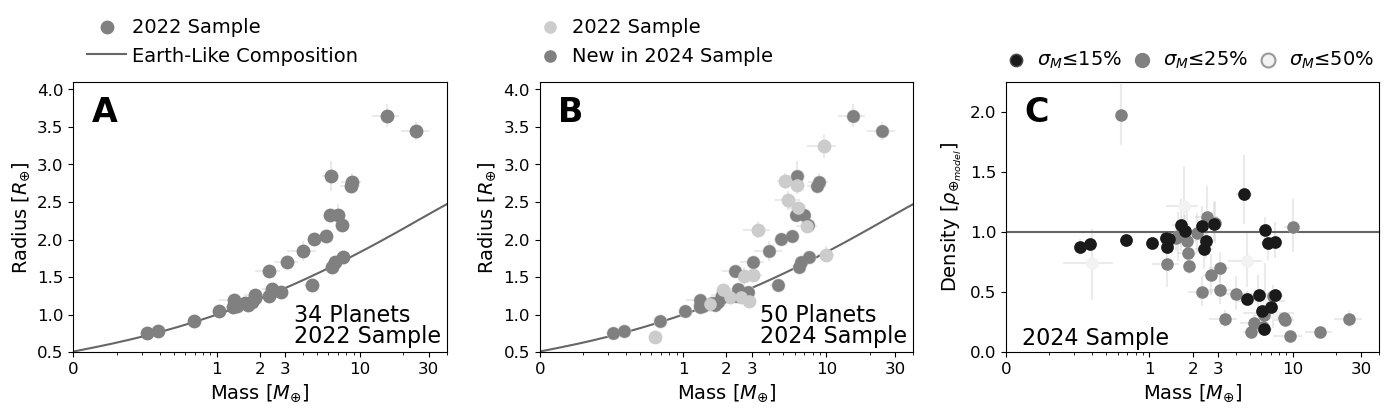

In [115]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4),sharex = True)
def format_func(value, tick_number):
    return int(value)

# Add subplot A
ax = axes[0]
norm = mcolors.Normalize(vmin=300, vmax=1200)
cmap = plt.cm.get_cmap('YlOrBr_r')

ax.scatter(mass1, radius1, color = "0.5",marker='o', s=80,label="2022 Sample")
ax.errorbar(mass1, radius1, xerr=mass_err1, yerr=radius_err1, fmt='.', markersize=15, color="0.8", zorder=-32, alpha=0.4)
ax.plot(list(earth_like_rocky["Mass"]), list(earth_like_rocky["Radius"]), "-", color=earth, label="Earth-Like Composition",zorder = -10)
ax.set_xlim(0.1, 40)
ax.set_ylim(0.5, 4.1)
ax.set_ylabel("Radius $[R_{\oplus}]$",fontsize  =14)
ax.legend(bbox_to_anchor=(0.4, 1.15), loc='center', columnspacing=0.8, facecolor="white",frameon=False, ncol=1,handletextpad=0.3,fontsize = 14)
ax.text(0.05, 0.95, "A", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax.text(0.59, 0.1, "2022 Sample", transform=ax.transAxes, fontsize=16, fontweight='normal', va='top', ha='left')
ax.text(0.59, 0.18, "34 Planets", transform=ax.transAxes, fontsize=16, fontweight='normal', va='top', ha='left')

ax.set_xscale('log')
ax.tick_params(left=True, which='both', labelsize=12)
ax.tick_params(bottom=True, which='both', labelsize=12)

ax.set_xticks([0.1, 1, 2,3, 10,30])  # Setting x-axis ticks for ax2
ax.xaxis.set_major_formatter(FuncFormatter(format_func))
ax.set_xlim(0.1,40)  # Setting x-axis ticks for ax2
ax.set_xlabel("Mass [$M_{\oplus}]$",fontsize  =14)


# Add subplot B
ax = axes[1]
norm = mcolors.Normalize(vmin=300, vmax=1200)
cmap = plt.cm.get_cmap('YlOrBr_r')
scatter_b = ax.scatter(mass, radius, color = "0.8", marker='o', s=80)
ax.plot(list(earth_like_rocky["Mass"]), list(earth_like_rocky["Radius"]), "-", color=earth,zorder = -10)
ax.scatter(mass1, radius1, color = "0.5", marker='o', s=65)
ax.scatter(mass2, radius2, color = "0.8", marker='o', s=65,label="2022 Sample")
ax.scatter(100, 100, color = "0.5", marker='o', s=65,label="New in 2024 Sample")
ax.errorbar(mass, radius, xerr=mass_err, yerr=radius_err, fmt='.', markersize=15, color="0.8", zorder=-32, alpha=0.4)
ax.set_xlim(0.1, 40)
ax.set_ylim(0.5, 4.1)
ax.set_xscale('log')
ax.set_ylabel("Radius $[R_{\oplus}]$",fontsize  =14)
ax.legend(bbox_to_anchor=(0.3, 1.15), loc='center', columnspacing=1,facecolor="white", frameon=False, ncol=1,handletextpad=0.1,fontsize = 14)
ax.text(0.05, 0.95, "B", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax.text(0.59, 0.1, "2024 Sample", transform=ax.transAxes, fontsize=16, fontweight='normal', va='top', ha='left')
ax.text(0.59, 0.18, "50 Planets", transform=ax.transAxes, fontsize=16, fontweight='normal', va='top', ha='left')

ax.set_xticks([0.1, 1, 2,3, 10,30])  # Setting x-axis ticks for ax2
ax.xaxis.set_major_formatter(FuncFormatter(format_func))

ax.set_xlabel("Mass [$M_{\oplus}]$",fontsize  =14)

ax.tick_params(left=True, which='both', labelsize=12)
ax.tick_params(bottom=True, which='both', labelsize=12)


# Add subplot C
ax = axes[2]
planets = ["K2-146 b",'TRAPPIST-1 h', 'TRAPPIST-1 d', 'TRAPPIST-1 e', 'TRAPPIST-1 f', 'TRAPPIST-1 g', 'TRAPPIST-1 c', 'TRAPPIST-1 b', 'GJ 1132 b', 'TOI-270 b', 'GJ 3053 c', 'GJ 1252 b', 'GJ 357 b', 'LTT 3780 b', 'LHS 1478 b', 'GJ 486 b', 'GJ 3473 b', 'CD-60 8051 b', 'L 98-59 c', 'L 98-59 d', 'GJ 3053 b', 'TOI-270 d', 'TOI-776 b', 'TOI-1634 b', 'TOI-1685 b', 'TOI-1235 b', 'K2-146 c', 'LTT 3780 c', 'TOI-270 c', 'K2-18 b', 'TOI-269 b', 'GJ 1214 b', 'K2-25 b', 'TOI-1231 b']
planet1filter      = []; 
radius1filter      = []; 
mass1filter        = []; mass_up1filter        = []; mass_low1filter    = []
density1filter     = []; density_up1filter     = []; density_low1filter = []

filter_value = 0.50
for i in range(0,len(planet_name_LI)):
    if planet_name_LI[i] in planets: 
        if ((mass_unc_up_LI[i]+mass_unc_low_LI[i])/2)/mass_LI[i] < filter_value:
            planet1filter.append(planet_name_LI[i]); 
            radius1filter.append(radius_LI[i]);
            mass1filter.append(mass_LI[i]);          mass_up1filter.append(mass_unc_up_LI[i]);      mass_low1filter.append(mass_unc_low_LI[i]);
            density1filter.append(density_LI[i]);    density_up1filter.append(density_unc_up_LI[i]); density_low1filter.append(density_unc_low_LI[i]);


planet_EA_unique = list(set(planet_name_EA))
other_names = ["LHS 1140 b",'LHS 1140 c' ,'L 168-9 b', 'L 168-9 c', "GJ 3053 b","GJ 3053 c"]

radius_4_crit     = []
mass_err_crit     = []
radius_err_crit   = []
stellar_type_crit = []
st_eff_crit       = []
density_crit      = []
for i in range(0,len(planet_name_EA)):
    if planet_name_EA[i] not in planet_name_LI and planet_name_EA[i] not in other_names and planet_name_EA[i]:
        if planet_name_EA[i] not in radius_4_crit and radius_EA[i]<4:
            radius_4_crit.append(planet_name_EA[i])
        if planet_name_EA[i] not in mass_err_crit and ((mass_unc_up_EA[i] + mass_unc_up_EA[i])*0.5) / mass_EA[i] < filter_value:
            mass_err_crit.append(planet_name_EA[i])    
        if planet_name_EA[i] not in radius_err_crit and ((radius_unc_up_EA[i] + radius_unc_up_EA[i])*0.5) / radius_EA[i] < 0.08:
            radius_err_crit.append(planet_name_EA[i])   
        if planet_name_EA[i] not in stellar_type_crit and "M" in str(st_spectype_EA[i]):
            stellar_type_crit.append(planet_name_EA[i])   
        if planet_name_EA[i] not in density_crit and True != math.isnan(density_unc_up_EA[i]):
            density_crit.append(planet_name_EA[i])   

list1 = radius_4_crit;   list2 = mass_err_crit; 
list3 = radius_err_crit; list4 = stellar_type_crit; 
list5 = density_crit

common_elements = np.sort(list(set(list1) & set(list2) & set(list3) & set(list4) & set(list5)))

planetfilter      = []
radiusfilter      = []; 
massfilter        = []; mass_upfilter        = []; mass_lowfilter    = []
densityfilter     = []; density_upfilter     = []; density_lowfilter = []

for j in range(0,len(common_elements)):
    target_string = str(common_elements[j])
    indexs = [index for index, value in enumerate(planet_name_EA) if value == target_string]
    i = indexs[0]
    if st_eff_EA[i] < 4000:
        planetfilter.append(planet_name_EA[i]);
        radiusfilter.append(dataEA.pl_rade[i]); 
        densityfilter.append(dataEA.pl_dens[i]); density_upfilter.append(dataEA.pl_denserr1[i]); density_lowfilter.append(dataEA.pl_denserr2[i])
        massfilter.append(dataEA.pl_bmasse[i]); mass_upfilter.append(dataEA.pl_bmasseerr1[i]);  mass_lowfilter.append(dataEA.pl_bmasseerr2[i])

mass_1filter_err = [np.abs(mass_low1filter),mass_up1filter]
mass_filter_err = [np.abs(mass_lowfilter),mass_upfilter]
density_filter_err = [np.array(np.abs(density_lowfilter))/ rocky_density(massfilter),np.array(density_upfilter)/ rocky_density(massfilter)]
density_1filter_err = [np.array(np.abs(density_low1filter))/ rocky_density(mass1filter),np.array(density_up1filter)/ rocky_density(mass1filter)]

ax.errorbar(massfilter, np.array(densityfilter)/ rocky_density(massfilter), xerr=mass_filter_err, yerr= density_filter_err,fmt='.', markersize=15, color="0.8", zorder=-32, alpha=0.4)
ax.errorbar(mass1filter, np.array(density1filter)/ rocky_density(mass1filter), xerr=mass_1filter_err,yerr = density_1filter_err, fmt='.', markersize=15, color="0.8", zorder=-32, alpha=0.4)
ax.plot(mass1filter,np.array(density1filter)/ rocky_density(mass1filter),".",markersize = 16,color = "0.95")
filter50 = plt.plot(massfilter,np.array(densityfilter)/ rocky_density(massfilter),".",markersize = 16, color = "0.95",label = r"$σ_{M} ≤ 50\%$")
print(len(massfilter))

#### 25 % ######
planet1filter      = []; 
radius1filter      = []; 
mass1filter        = []; mass_up1filter        = []; mass_low1filter    = []
density1filter     = []; density_up1filter     = []; density_low1filter = []

filter_value = 0.25
for i in range(0,len(planet_name_LI)):
    if planet_name_LI[i] in planets: 
        if ((mass_unc_up_LI[i]+mass_unc_low_LI[i])/2)/mass_LI[i] < filter_value:
            planet1filter.append(planet_name_LI[i]); 
            radius1filter.append(radius_LI[i]);
            mass1filter.append(mass_LI[i]);          mass_up1filter.append(mass_unc_up_LI[i]);      mass_low1filter.append(mass_unc_low_LI[i]);
            density1filter.append(density_LI[i]);    density_up1filter.append(density_unc_up_LI[i]); density_low1filter.append(density_unc_low_LI[i]);


planet_EA_unique = list(set(planet_name_EA))
other_names = ["LHS 1140 b",'LHS 1140 c' ,'L 168-9 b', 'L 168-9 c', "GJ 3053 b","GJ 3053 c"]

radius_4_crit     = []
mass_err_crit     = []
radius_err_crit   = []
stellar_type_crit = []
st_eff_crit       = []
density_crit      = []
for i in range(0,len(planet_name_EA)):
    if planet_name_EA[i] not in planet_name_LI and planet_name_EA[i] not in other_names and planet_name_EA[i]:
        if planet_name_EA[i] not in radius_4_crit and radius_EA[i]<4:
            radius_4_crit.append(planet_name_EA[i])
        if planet_name_EA[i] not in mass_err_crit and ((mass_unc_up_EA[i] + mass_unc_up_EA[i])*0.5) / mass_EA[i] < filter_value:
            mass_err_crit.append(planet_name_EA[i])    
        if planet_name_EA[i] not in radius_err_crit and ((radius_unc_up_EA[i] + radius_unc_up_EA[i])*0.5) / radius_EA[i] < 0.08:
            radius_err_crit.append(planet_name_EA[i])   
        if planet_name_EA[i] not in stellar_type_crit and "M" in str(st_spectype_EA[i]):
            stellar_type_crit.append(planet_name_EA[i])   
        if planet_name_EA[i] not in density_crit and True != math.isnan(density_unc_up_EA[i]):
            density_crit.append(planet_name_EA[i])   

list1 = radius_4_crit;   list2 = mass_err_crit; 
list3 = radius_err_crit; list4 = stellar_type_crit; 
list5 = density_crit

common_elements = np.sort(list(set(list1) & set(list2) & set(list3) & set(list4) & set(list5)))

planetfilter      = []
radiusfilter      = []; 
massfilter        = []; mass_upfilter        = []; mass_lowfilter    = []
densityfilter     = []; density_upfilter     = []; density_lowfilter = []

for j in range(0,len(common_elements)):
    target_string = str(common_elements[j])
    indexs = [index for index, value in enumerate(planet_name_EA) if value == target_string]
    i = indexs[0]
    if st_eff_EA[i] < 4000:
        planetfilter.append(planet_name_EA[i]);
        radiusfilter.append(dataEA.pl_rade[i]); 
        densityfilter.append(dataEA.pl_dens[i]); density_upfilter.append(dataEA.pl_denserr1[i]); density_lowfilter.append(dataEA.pl_denserr2[i])
        massfilter.append(dataEA.pl_bmasse[i]); mass_upfilter.append(dataEA.pl_bmasseerr1[i]);  mass_lowfilter.append(dataEA.pl_bmasseerr2[i])

filter25 = plt.plot(mass1filter,np.array(density1filter)/ rocky_density(mass1filter),".",markersize = 16,color = "0.5",label =r"$σ_{M} ≤ 25\%$")
ax.plot(massfilter,np.array(densityfilter)/ rocky_density(massfilter),".",markersize = 16, color = "0.5")
print(len(massfilter))


#### 15 % ######
planet1filter      = []; 
radius1filter      = []; 
mass1filter        = []; mass_up1filter        = []; mass_low1filter    = []
density1filter     = []; density_up1filter     = []; density_low1filter = []

filter_value = 0.15
for i in range(0,len(planet_name_LI)):
    if planet_name_LI[i] in planets: 
        if ((mass_unc_up_LI[i]+mass_unc_low_LI[i])/2)/mass_LI[i] < filter_value:
            planet1filter.append(planet_name_LI[i]); 
            radius1filter.append(radius_LI[i]);
            mass1filter.append(mass_LI[i]);          mass_up1filter.append(mass_unc_up_LI[i]);      mass_low1filter.append(mass_unc_low_LI[i]);
            density1filter.append(density_LI[i]);    density_up1filter.append(density_unc_up_LI[i]); density_low1filter.append(density_unc_low_LI[i]);


planet_EA_unique = list(set(planet_name_EA))
other_names = ["LHS 1140 b",'LHS 1140 c' ,'L 168-9 b', 'L 168-9 c', "GJ 3053 b","GJ 3053 c"]

radius_4_crit     = []
mass_err_crit     = []
radius_err_crit   = []
stellar_type_crit = []
st_eff_crit       = []
density_crit      = []
for i in range(0,len(planet_name_EA)):
    if planet_name_EA[i] not in planet_name_LI and planet_name_EA[i] not in other_names and planet_name_EA[i]:
        if planet_name_EA[i] not in radius_4_crit and radius_EA[i]<4:
            radius_4_crit.append(planet_name_EA[i])
        if planet_name_EA[i] not in mass_err_crit and ((mass_unc_up_EA[i] + mass_unc_up_EA[i])*0.5) / mass_EA[i] < filter_value:
            mass_err_crit.append(planet_name_EA[i])    
        if planet_name_EA[i] not in radius_err_crit and ((radius_unc_up_EA[i] + radius_unc_up_EA[i])*0.5) / radius_EA[i] < 0.08:
            radius_err_crit.append(planet_name_EA[i])   
        if planet_name_EA[i] not in stellar_type_crit and "M" in str(st_spectype_EA[i]):
            stellar_type_crit.append(planet_name_EA[i])   
        if planet_name_EA[i] not in density_crit and True != math.isnan(density_unc_up_EA[i]):
            density_crit.append(planet_name_EA[i])   

list1 = radius_4_crit;   list2 = mass_err_crit; 
list3 = radius_err_crit; list4 = stellar_type_crit; 
list5 = density_crit

common_elements = np.sort(list(set(list1) & set(list2) & set(list3) & set(list4) & set(list5)))

planetfilter      = []
radiusfilter      = []; 
massfilter        = []; mass_upfilter        = []; mass_lowfilter    = []
densityfilter     = []; density_upfilter     = []; density_lowfilter = []

for j in range(0,len(common_elements)):
    target_string = str(common_elements[j])
    indexs = [index for index, value in enumerate(planet_name_EA) if value == target_string]
    i = indexs[0]
    if st_eff_EA[i] < 4000:
        planetfilter.append(planet_name_EA[i]);
        radiusfilter.append(dataEA.pl_rade[i]); 
        densityfilter.append(dataEA.pl_dens[i]); density_upfilter.append(dataEA.pl_denserr1[i]); density_lowfilter.append(dataEA.pl_denserr2[i])
        massfilter.append(dataEA.pl_bmasse[i]); mass_upfilter.append(dataEA.pl_bmasseerr1[i]);  mass_lowfilter.append(dataEA.pl_bmasseerr2[i])


plt.plot(mass1filter,np.array(density1filter)/ rocky_density(mass1filter),".",markersize = 16,color = "0.1")
filter15 = plt.scatter(100,100,s = 80, color = "0.1",label = r"$σ_{M} ≤ 15\%$",edgecolor = "0.3")
earth_line = plt.plot(earth_like_rocky["Mass"], np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))), "-", color=earth, label="Earth-Like Composition",zorder = -10)

filter50 = plt.scatter(100,100,s = 100, color = "0.95",label = r"$σ_{M} ≤ 50\%$",edgecolor = "0.6",linewidths=1.5)
filter25 = plt.scatter(100,100,s = 100, color = "0.5",label = r"$σ_{M} ≤ 25\%$")

ax.legend(handles=[filter15,filter25,filter50],bbox_to_anchor=(0.48, 1.08), loc='center',columnspacing=0.,frameon=False, ncol=3,handletextpad=0.1,fontsize =14)
ax.text(0.13, 0.21, "2024 Sample", fontsize=16, fontweight='normal', va='top', ha='left')
ax.set_xscale('log')
ax.text(0.05, 0.95, "C", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

ax.set_xticks([0.1, 1, 2,3, 10,30])  # Setting x-axis ticks for ax2
ax.xaxis.set_major_formatter(FuncFormatter(format_func))
ax.set_xlim(0.1,40)  # Setting x-axis ticks for ax2
ax.set_ylim(0,2.25)  # Setting x-axis ticks for ax2

ax.tick_params(left=True, which='both',labelsize = 12)
ax.tick_params(bottom=True, which='both',labelsize = 12)
ax.set_xlabel("Mass [$M_{\oplus}]$",fontsize  =14)
ax.set_ylabel("Density $[ρ_{ \oplus_{model}}]$",fontsize  =14)
folder_path = 'Figures_WhereAreTheWaterWorlds'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Define the image name within the folder
image_name = os.path.join(folder_path, 'Sample_alt.png')

# Set the image format
image_format = 'png'

plt.tight_layout(pad = 0.001)
fig.savefig(image_name, format=image_format, dpi=300)

In [117]:
radius_water = np.linspace(0.01, 4, 100)
mass_water   = 0.45081*radius_water**(100/27)

water_mass_g        = earth_Mass*mass_water
water_radius_cm     = earth_Radius*radius_water
water_density_g_cm3 = (water_mass_g) / ((4/3)*(np.pi)*(np.power(water_radius_cm,3))) 

def water_density(mass):
    x_points  = mass_water
    y_points  = water_density_g_cm3/rocky_density(mass_water)
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

def h20model_density(mass):
    x_points  = H20_50_500K["Mass"]
    y_points  = H20_50_500K_density_g_cm3/rocky_density(H20_50_500K["Mass"])
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

In [119]:
mass_water = np.linspace(0.1, 30, 100)
radius_water   = 1.24*(mass_water**(0.27))

def water_radius(mass):
    x_points  = mass_water
    y_points  = radius_water
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

def water_mass(radius):
    y_points  = mass_water
    x_points  = radius_water
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(radius, tck).tolist()

In [120]:
bins  = np.linspace(0, 2.25, 35)
pbins  = np.linspace(0, 2.25, 100)
density_norm_planet = np.array(density1) / rocky_density(mass1)

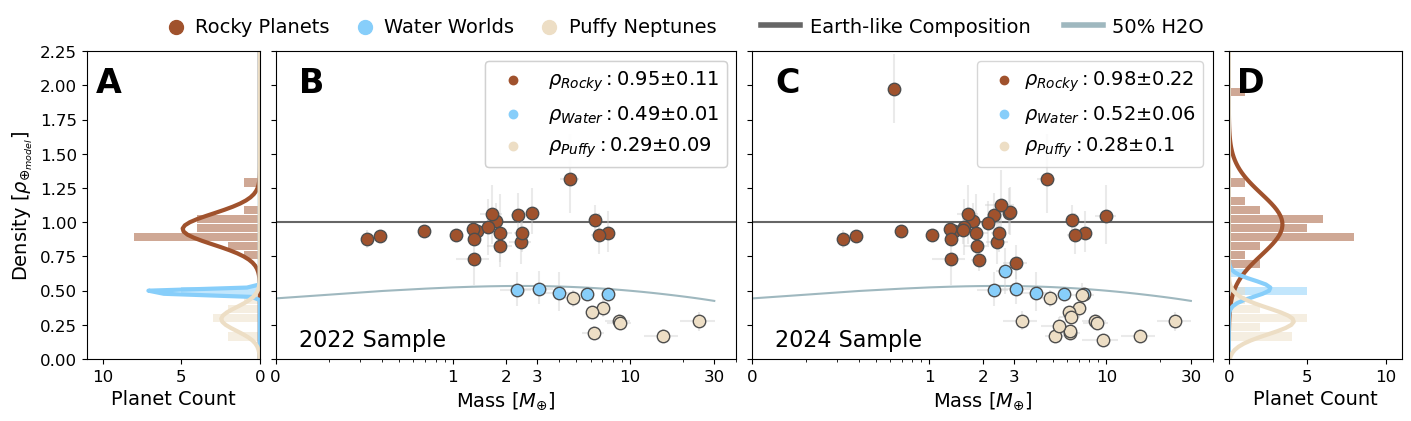

In [174]:
bins  = np.linspace(0, 2.25, 35)
pbins  = np.linspace(0, 2.25, 100)
density_norm_planet = np.array(density1) / rocky_density(mass1)

width_ratios = [3,8,8,3]
fig, axes = plt.subplots(figsize=(14, 4), ncols=4, nrows=1, gridspec_kw={'width_ratios': width_ratios}, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.2, left=0.06, right=0.999, top=0.9, bottom=0.13)

# Unpack the axes
ax1, ax2, ax3, ax4 = axes

ax2.plot(earth_like_rocky["Mass"], np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))), "-", color=earth, label="Earth-like", zorder=-32)
ax2.plot(mass_water, water_density_g_cm3 / rocky_density(mass_water), "-", color=h20, label="50% H2O", zorder=-32)     
#ax2.plot(H20_50_500K["Mass"], h20model_density(H20_50_500K["Mass"]), "-", color=h20, label="50% H2O", zorder=-32)


# Add subplot A 
index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(mass1)):
    if  water_mass(radius1[i]) < mass1[i]-mass_up1[i] and water_radius(mass1[i]) > radius1[i]+radius_up1[i]:
        index_rocky.append(i)
    elif  water_radius(mass1[i]) < radius1[i]-np.abs(radius_low1[i]):
        index_puffy.append(i)
    else:
        index_water.append(i)

###### Rocky Planets #####
indexs  = index_rocky
ax1.hist(density_norm_planet[indexs], bins=bins, color=rocky, alpha=0.5, rwidth=0.9, density=False,orientation = 'horizontal')
mu = np.average(density_norm_planet[indexs])
sigma = np.sqrt(np.cov(density_norm_planet[indexs], ddof=0))
raw_counts, bin_edges = np.histogram(density_norm_planet[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density_norm_planet[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
ax1.plot(best_fit_line,pbins,color = rocky,linewidth=3)
scatterrocky22 = ax2.scatter(100,100, label ="$ρ_{Rocky}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color =rocky)

##### Water Worlds #####
indexs  = index_water
ax1.hist(density_norm_planet[indexs], bins=bins, color=water, alpha=0.5,rwidth=0.9, density=False,orientation = 'horizontal')
mu = np.average(density_norm_planet[indexs])
sigma = np.sqrt(np.cov(density_norm_planet[indexs], ddof=0))
raw_counts, bin_edges = np.histogram(density_norm_planet[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density_norm_planet[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
ax1.plot(best_fit_line,pbins,color = water,linewidth=3)
scatterwater22 = ax2.scatter(100,100,label ="$ρ_{Water}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = water)

##### Puffy Neptunes #####
indexs  = index_puffy
ax1.hist(density_norm_planet[indexs], bins=bins, color=puffy, alpha=0.5,rwidth=0.9, density=False,orientation = 'horizontal')
mu = np.average(density_norm_planet[indexs])
sigma = np.sqrt(np.cov(density_norm_planet[indexs],ddof=0))
raw_counts, bin_edges = np.histogram(density_norm_planet[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density_norm_planet[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
ax1.plot(best_fit_line,pbins,color = puffy,linewidth=3)
scatterpuffy22 = ax2.scatter(100,100, label ="$ρ_{Puffy}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = puffy)

# Add subplot B
index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(mass1)):
    if  water_mass(radius1[i]) < mass1[i]-mass_up1[i] and water_radius(mass1[i]) > radius1[i]+radius_up1[i]:
        index_rocky.append(i)
    elif  water_radius(mass1[i]) < radius1[i]-np.abs(radius_low1[i]):
        index_puffy.append(i)
    else:
        index_water.append(i)
        
density_norm_planet = np.array(density1) / rocky_density(mass1)
ax2.scatter(np.array(mass1)[index_rocky], density_norm_planet[index_rocky],color = rocky,s=80, edgecolor = "0.3")
ax2.scatter(np.array(mass1)[index_water], density_norm_planet[index_water],color = water,s=80, edgecolor = "0.3")
ax2.scatter(np.array(mass1)[index_puffy], density_norm_planet[index_puffy],color = puffy,s=80, edgecolor = "0.3")
ax2.errorbar(mass1, density_norm_planet, xerr=mass_err1, yerr=density_err1_norm, fmt='.', markersize=15, color="0.8", zorder=-32, alpha=0.4)

# Add subplot C
earthline = ax3.plot(earth_like_rocky["Mass"], np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))), "-", color=earth, label="Earth-like", zorder=-32)
waterline = ax3.plot(mass_water, water_density_g_cm3 / rocky_density(mass_water), "-", color=h20, label="50% H2O", zorder=-32)     


index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(mass)):
    if  water_mass(radius[i]) < mass[i]-mass_up[i] and water_radius(mass[i]) > radius[i]+radius_up[i]:
        index_rocky.append(i)
    elif  water_radius(mass[i]) < radius[i]-np.abs(radius_low[i]):
        index_puffy.append(i)
    else:
        index_water.append(i)

ax3.scatter(np.array(mass)[index_rocky], density[index_rocky],color = rocky,s=80, edgecolor = "0.3")
ax3.scatter(np.array(mass)[index_water], density[index_water],color = water,s=80, edgecolor = "0.3")
ax3.scatter(np.array(mass)[index_puffy], density[index_puffy],color = puffy,s=80, edgecolor = "0.3")
ax3.errorbar(mass, density, xerr=mass_err, yerr=density_err, fmt='.', markersize=15, color="0.8", zorder=-32, alpha=0.4)

# Add subplot D
index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(mass)):
    if  water_mass(radius[i]) < mass[i]-mass_up[i] and water_radius(mass[i]) > radius[i]+radius_up[i]:
        index_rocky.append(i)
    elif  water_radius(mass[i]) < radius[i]-np.abs(radius_low[i]):
        index_puffy.append(i)
    else:
        index_water.append(i)
###### Rocky Planets #####
indexs  = index_rocky
ax4.hist(density[indexs], bins=bins, color=rocky, alpha=0.5, rwidth=0.9, density=False,orientation = 'horizontal')
mu = np.average(density[indexs])
sigma = np.sqrt(np.cov(density[indexs], ddof=0))
raw_counts, bin_edges = np.histogram(density[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
ax4.plot(best_fit_line,pbins,color = rocky,linewidth=3)
scatterrocky24 = ax3.scatter(100,100, label ="$ρ_{Rocky}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = rocky)

##### Water Worlds #####
indexs  = index_water
ax4.hist(density[indexs], bins=bins, color=water, alpha=0.5,rwidth=0.9, density=False,orientation = 'horizontal')
mu = np.average(density[indexs])
sigma = np.sqrt(np.cov(density[indexs], ddof=0))
raw_counts, bin_edges = np.histogram(density[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
ax4.plot(best_fit_line,pbins,color = water,linewidth=3)
scatterwater24 = ax3.scatter(100,100, label ="$ρ_{Water}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = water)

##### Puffy Neptunes #####
indexs  = index_puffy
ax4.hist(density[indexs], bins=bins, color=puffy, alpha=0.5,rwidth=0.9, density=False,orientation = 'horizontal')
mu = np.average(density[indexs])
sigma = np.sqrt(np.cov(density[indexs],ddof=0))
raw_counts, bin_edges = np.histogram(density[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
ax4.plot(best_fit_line,pbins, color = puffy,linewidth=3)
scatterpuffy24 = ax3.scatter(100,100,label ="$ρ_{Puffy}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = puffy)

# Set labels and legends:
ax1.text(0.05, 0.95, "A", transform=ax1.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax2.text(0.05, 0.95, "B", transform=ax2.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax3.text(0.05, 0.95, "C", transform=ax3.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax4.text(0.05, 0.95, "D", transform=ax4.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

ax2.text(0.05, 0.1, "2022 Sample", transform=ax2.transAxes, fontsize=16, fontweight='normal', va='top', ha='left')
ax3.text(0.05, 0.1, "2024 Sample", transform=ax3.transAxes, fontsize=16, fontweight='normal', va='top', ha='left')

ax1.set_xlabel("Planet Count",fontsize = 14)
ax2.set_xlabel("Mass [$M_{\oplus}]$",fontsize = 14)
ax3.set_xlabel("Mass [$M_{\oplus}]$",fontsize = 14)
ax4.set_xlabel("Planet Count",fontsize = 14)

ax1.set_ylabel("Density $[ρ_{ \oplus_{model}}]$",fontsize = 14)

ax2.set_xlim(0.1, 40)
ax2.set_ylim(0, 2.25)
ax2.set_xscale('log')

ax3.set_xlim(0.1, 40)
ax3.set_ylim(0, 2.25)
ax3.set_xscale('log')

ax1.set_xlim(0, 11)
ax4.set_xlim(0, 11)

def format_func(value, tick_number):
    return int(value)

ax2.set_xticks([0.1, 1, 2,3, 10,30])  # Setting x-axis ticks for ax2
ax2.xaxis.set_major_formatter(FuncFormatter(format_func))

ax3.set_xticks([0.1, 1, 2,3, 10,30])  # Setting x-axis ticks for ax3
ax3.xaxis.set_major_formatter(FuncFormatter(format_func))

puffydot = ax3.scatter(100,100,label ="Puffy Neptunes",color = puffy,s = 100)
rockydot = ax3.scatter(100,100,label ="Rocky Planets",color = rocky,s = 100)
waterdot = ax3.scatter(100,100,label = "Water Worlds",color = water,s = 100)

# Creating the first legend for the plot
first_legend = ax2.legend(handles=[scatterrocky22,scatterwater22,scatterpuffy22], loc='upper right',facecolor = "white",fontsize = 14)
ax2.add_artist(first_legend)
ax1.legend(handles=[rockydot, waterdot, puffydot], bbox_to_anchor=(0.3, 1.08), loc='center left',columnspacing = 0.8, frameon=False, ncol=3,handletextpad=0.0001,fontsize = 14)

first_legend = ax3.legend(handles=[scatterrocky24,scatterwater24,scatterpuffy24], loc='upper right',facecolor = "white",fontsize = 14, handletextpad=0.0001)
ax3.add_artist(first_legend)

earthline1 = ax3.plot(100,100, "-", color=earth, label="Earth-like Composition", lw = 4)
waterline1 = ax3.plot(100,100, "-", color=h20, label="50% H2O", lw = 4)

ax3.legend(handles=[earthline1[0],waterline1[0]], bbox_to_anchor=(0.5, 1.08), loc='center',columnspacing = 1.7, frameon=False, ncol=2,handletextpad=0.5,fontsize = 14)
ax1.invert_xaxis()

ax1.tick_params(left=True, which='both',labelsize = 12)
ax1.tick_params(bottom=True, which='both',labelsize = 12)
ax2.tick_params(bottom=True, which='both',labelsize = 12)
ax3.tick_params(bottom=True, which='both',labelsize = 12)
ax4.tick_params(bottom=True, which='both',labelsize = 12)
folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)


image_name = os.path.join(folder_path, 'Samples_LP_compare.png')
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=300)

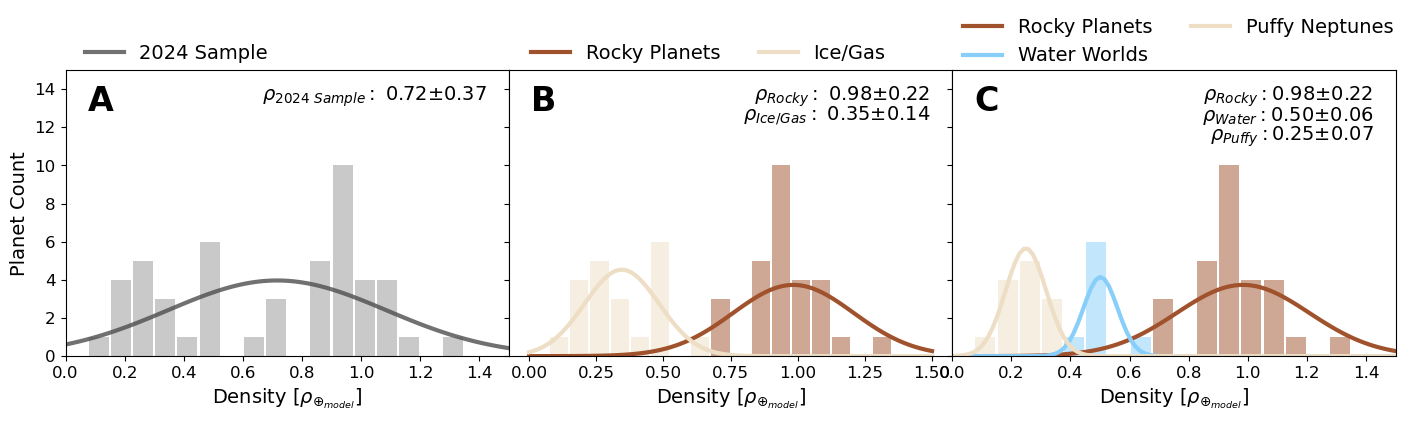

In [350]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4),sharey = True)
plt.subplots_adjust(wspace=0, hspace=0.2, left=0.04, right=0.99, top=0.85, bottom=0.135)
bins  = np.linspace(0, 1.5, 21)
pbins  = np.linspace(0, 1.5, 100)

ax = axes[0]
###### Planets #####
ax.hist(density, bins=bins, color='0.3', alpha=0.3, rwidth=0.9, density=False)
ax.set_xlim(0, 1.5); ax.set_ylim(0, 14)
ax.set_xlabel("Density $[ρ_{ \oplus_{model}}]$",fontsize = 14)
ax.set_ylabel("Planet Count",fontsize = 14)
ax.text(0.05, 0.95, "A", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
mu = np.average(density)
sigma = np.sqrt(np.cov(density, ddof=0))
raw_counts, bin_edges = np.histogram(density, bins=bins)
normalized_counts, bin_edges = np.histogram(density, bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
ax.plot(pbins, best_fit_line,label ="2024 Sample",color = "0.3",linewidth=3,alpha = 0.8)
leg = ax.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
ax.legend(fontsize = 14,bbox_to_anchor=(0.25, 1.06), loc='center',frameon=False)
ax.tick_params(bottom=True, which='both',labelsize  = 12)
ax.tick_params(left=True, which='both',labelsize  = 12)
ax.text(0.95, 0.95, "$ρ_{2024 \ Sample}:$ "+str(np.round(mu,2))+"±"+str(np.round(sigma,2)), transform=ax.transAxes, fontsize=14, fontweight='light', va='top', ha='right')


ax = axes[1]
###### Rocky Planets #####
indexs  = index_rocky 
ax.hist(density[indexs], bins=bins, color=rocky, alpha=0.5, rwidth=0.9, density=False)
mu = np.average(density[indexs])
sigma = np.sqrt(np.cov(density[indexs], ddof=0))
raw_counts, bin_edges = np.histogram(density[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
ax.plot(pbins, best_fit_line,label ="Rocky Planets",color = rocky,linewidth=3)
ax.text(0.95, 0.95, "$ρ_{Rocky}:$ "+str(np.round(mu,2))+"±"+str(np.round(sigma,2)), transform=ax.transAxes, fontsize=14, fontweight='light', va='top', ha='right')

##### Water + Gas Worlds #####
indexs  = index_water + index_puffy
ax.hist(density[indexs], bins=bins, color=puffy, alpha=0.5,rwidth=0.9, density=False)
mu = np.average(density[indexs])
sigma = np.sqrt(np.cov(density[indexs], ddof=0))
raw_counts, bin_edges = np.histogram(density[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
ax.plot(pbins, best_fit_line,label ="Ice/Gas",color = puffy,linewidth=3)
leg = ax.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
ax.legend(fontsize = 14,bbox_to_anchor=(0.45, 1.06), loc='center',frameon=False,ncol = 2)
ax.set_xlabel("Density $[ρ_{ \oplus_{model}}]$",fontsize = 14)
ax.text(0.05, 0.95, "B", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax.tick_params(bottom=True, which='both',labelsize  = 12)
ax.text(0.95, 0.88, "$ρ_{Ice/Gas}:$ "+str(np.round(mu,2))+"±"+str(np.round(sigma,2)), transform=ax.transAxes, fontsize=14, fontweight='light', va='top', ha='right')


ax = axes[2]
index_puffy = []; index_water = []; index_rocky = []
for i in range(0, len(density)):
    if density[i] - np.abs(density_low[i]) > h20model_density(mass[i]):
        index_rocky.append(i)
    elif density[i] - np.abs(density_low[i]) < h20model_density(mass[i]) and density[i] + np.abs(density_up[i]) > h20model_density(mass[i]):
        index_water.append(i)
    else: 
        index_puffy.append(i)
###### Rocky Planets #####
indexs  = index_rocky
ax.hist(density[indexs], bins=bins, color=rocky, alpha=0.5, rwidth=0.9, density=False)
mu = np.average(density[indexs])
sigma = np.sqrt(np.cov(density[indexs], ddof=0))
raw_counts, bin_edges = np.histogram(density[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
ax.plot(pbins, best_fit_line,label ="Rocky Planets",color = rocky,linewidth=3)
ax.text(0.95, 0.95, "$ρ_{Rocky}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)), transform=ax.transAxes, fontsize=14, fontweight='light', va='top', ha='right')

##### Water Worlds #####
indexs  = index_water
ax.hist(density[indexs], bins=bins, color=water, alpha=0.5,rwidth=0.9, density=False)
mu = np.average(density[indexs])
sigma = np.sqrt(np.cov(density[indexs], ddof=0))
raw_counts, bin_edges = np.histogram(density[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
ax.plot(pbins, best_fit_line,label ="Water Worlds",color = water,linewidth=3)
ax.text(0.95, 0.88, "$ρ_{Water}:$"+"0.50"+"±"+str(np.round(sigma,2)), transform=ax.transAxes, fontsize=14, fontweight='light', va='top', ha='right')

##### Puffy Neptunes #####
indexs  = index_puffy
ax.hist(density[indexs], bins=bins, color=puffy, alpha=0.5,rwidth=0.9, density=False)
mu = np.average(density[indexs])
sigma = np.sqrt(np.cov(density[indexs],ddof=0))
raw_counts, bin_edges = np.histogram(density[indexs], bins=bins)
normalized_counts, bin_edges = np.histogram(density[indexs], bins=bins, density=True)
scale_factor = sum(raw_counts)/sum(normalized_counts)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*scale_factor
ax.plot(pbins, best_fit_line,label ="Puffy Neptunes",color = puffy,linewidth=3)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
ax.legend(fontsize = 14,bbox_to_anchor=(0.51, 1.1), loc='center',frameon=False,ncol = 2)
ax.set_xlim(0, 1.5); ax.set_ylim(0, 15)
ax.set_xlabel("Density $[ρ_{ \oplus_{model}}]$",fontsize = 14)
ax.text(0.05, 0.95, "C", transform=ax.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax.tick_params(bottom=True, which='both',labelsize  = 12)
ax.text(0.95, 0.81, "$ρ_{Puffy}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)), transform=ax.transAxes, fontsize=14, fontweight='light', va='top', ha='right')

folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

image_name = os.path.join(folder_path, 'Histograms_pops.png')
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=300)

## GMM 

In [264]:
colors =  [rocky,puffy]
custom_cmap3 = ListedColormap(colors)

colors =  [rocky,water,puffy]
custom_cmap4 = ListedColormap(colors)

n_init = 10
bins  = np.linspace(0, 1.5, 21)
pbins  = np.linspace(0, 1.5, 100)

In [271]:
mu = np.average(np.array(density)[indexs])


In [269]:
density[indexs]

TypeError: list indices must be integers or slices, not list

AIC: 14.629325487929746
BIC: 24.08842697848288
AIC: 6.68730384462485
BIC: 21.82186622950986


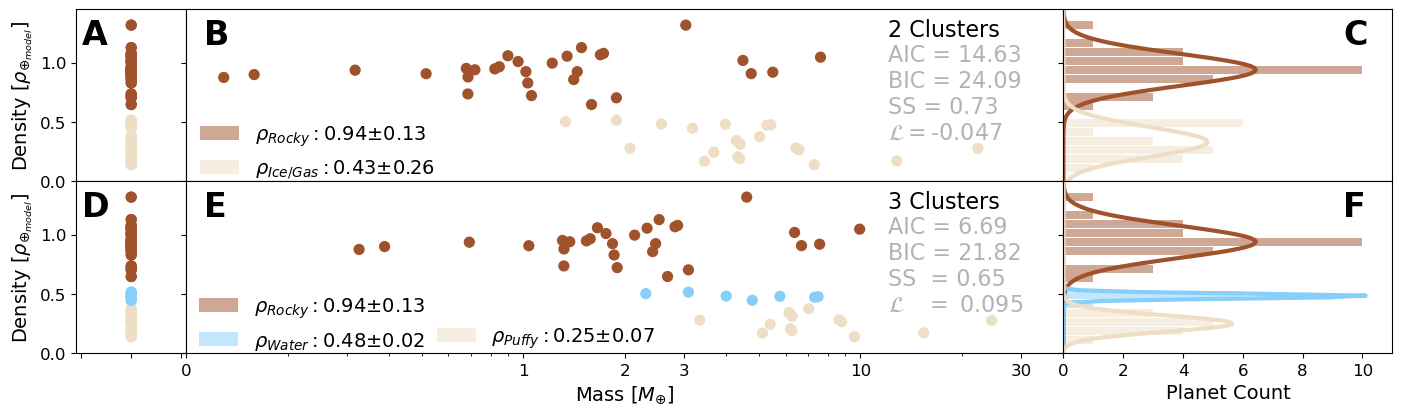

In [286]:
GJ_index_remove = list(planet_name).index("GJ 367 b")
mass    = np.concatenate((mass1, mass2)); mass_up  = np.concatenate((mass_up1, mass_up2));       mass_low     = np.concatenate((mass_low1, mass_low2));
mass10  = np.log10(mass)
density = np.concatenate((np.array(density1) / rocky_density(mass1), np.array(density2)/ rocky_density(mass2))); density_up  = np.concatenate((np.array(density_up1)/ rocky_density(mass1), np.array(density_up2)/ rocky_density(mass2))); density_low  = np.concatenate((np.array(density_low1)/ rocky_density(mass1),np.array(density_low2)/ rocky_density(mass2)));
density = list(density)
density.pop(GJ_index_remove)
mass10      = np.log10(mass)
mass10 = list(mass10)
mass10.pop(GJ_index_remove)
mass = list(mass)
mass.pop(GJ_index_remove)

data = np.array(density)
data = data.reshape(-1, 1)
n_components = 2
gmm = GaussianMixture(n_components=n_components, init_params='kmeans',n_init =n_init)
gmm.fit(data)
labels = gmm.predict(data)
norm = plt.Normalize(labels.min(), labels.max())

log_likelihood2 = gmm.score(data)
silhouette_score2 = metrics.silhouette_score(data, labels)
aic2 = gmm.aic(data)
bic2 = gmm.bic(data)

print("AIC:", aic2)
print("BIC:", bic2)
indices_label_0 = np.where(labels == 0); cluster_0_mean = np.mean(np.array(density)[list(indices_label_0[0])])
indices_label_1 = np.where(labels == 1); cluster_1_mean = np.mean(np.array(density)[list(indices_label_1[0])])
means_dict = {'0': cluster_0_mean, '1': cluster_1_mean}

# Find the variable with the smallest mean value
min_variable = int(min(means_dict, key=means_dict.get))
max_variable = int(max(means_dict, key=means_dict.get))
new_labels = list(np.zeros(len(mass)))

for i in range(len(mass)):
    if labels[i] == min_variable:
        new_labels[i] = 1
    if labels[i] == max_variable:
        new_labels[i] = 0

denisty_cluster0 = []; denisty_cluster1 = []; denisty_cluster2 = []; 
for i in range(0,len(new_labels)):
    if new_labels[i] == 0:
        denisty_cluster0.append(density[i])
    if new_labels[i] == 1:
        denisty_cluster1.append(density[i])
        
width_ratios = [1,8,3]

fig, axes = plt.subplots(figsize=(14, 4), ncols=3, nrows=2, gridspec_kw={'width_ratios': width_ratios}, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0, left=0.05, right=0.99, top=0.99, bottom=0.13)

# Unpack the axes
ax1, ax2, ax3 = axes[0]
ax4, ax5, ax6 = axes[1]

# Subplot A
ax1.scatter(np.zeros_like(data),data, c=new_labels, cmap=custom_cmap3, s=50,vmin=0, vmax=1)
ax1.scatter(np.zeros_like(data), data, c=new_labels, cmap=custom_cmap3, s=50, vmin=0, vmax=1)

# Subplot B
ax2.scatter(mass, density, c=new_labels, cmap=custom_cmap3, s=50, vmin=0, vmax=1)
GMM2 = new_labels

#Subplot C
hist_values_false, bin_edges, _ = ax3.hist(denisty_cluster0, bins=bins, color=rocky, orientation="horizontal",alpha=0.5, rwidth=0.9, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(denisty_cluster0)
mu0 = mu
sigma = np.sqrt(np.cov(denisty_cluster0, ddof=0))
sigma0 = sigma
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
ax3.plot(best_fit_line,pbins, color = rocky,linewidth=3)

hist_values_false, bin_edges, _ = ax3.hist(denisty_cluster1, bins=bins, color=puffy, orientation="horizontal",alpha=0.5, rwidth=0.9, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(denisty_cluster1)
mu1 = mu
sigma = np.sqrt(np.cov(denisty_cluster1, ddof=0))
sigma1 = sigma
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
ax3.plot(best_fit_line,pbins, color = puffy,linewidth=3)


# Subplot D
n_components = 3
gmm = GaussianMixture(n_components=n_components, init_params='kmeans',n_init = n_init)
gmm.fit(data)
labels = gmm.predict(data)

log_likelihood3 = gmm.score(data)
silhouette_score3 = metrics.silhouette_score(data, labels)
aic3 = gmm.aic(data)
bic3 = gmm.bic(data)

print("AIC:", aic3)
print("BIC:", bic3)
indices_label_0 = np.where(labels == 0); cluster_0_mean = np.mean(np.array(density)[list(indices_label_0[0])])
indices_label_1 = np.where(labels == 1); cluster_1_mean = np.mean(np.array(density)[list(indices_label_1[0])])
indices_label_2 = np.where(labels == 2); cluster_2_mean = np.mean(np.array(density)[list(indices_label_2[0])])
means_dict = {'0': cluster_0_mean, '1': cluster_1_mean, '2': cluster_2_mean}

# Find the variable with the smallest mean value
min_variable = int(min(means_dict, key=means_dict.get))
max_variable = int(max(means_dict, key=means_dict.get))
mid_variable = (set([0,1,2]) - set([min_variable,max_variable])).pop()
new_labels = list(np.zeros(len(mass)))

for i in range(0,len(mass)):
    if labels[i] == min_variable:
        new_labels[i] = 2
    if labels[i] == mid_variable:
        new_labels[i] = 1
    if labels[i] == max_variable:
        new_labels[i] = 0
    
denisty_cluster0 = []; denisty_cluster1 = []; denisty_cluster2 = []; 
for i in range(0,len(new_labels)):
    if new_labels[i] == 0:
        denisty_cluster0.append(density[i])
    if new_labels[i] == 1:
        denisty_cluster1.append(density[i])
    if new_labels[i] == 2:
        denisty_cluster2.append(density[i])

ax4.scatter(np.zeros_like(data),data, c=new_labels, cmap=custom_cmap4, s=50,vmin=0, vmax=2)
ax4.scatter(np.zeros_like(data), data, c=new_labels, cmap=custom_cmap4, s=50, vmin=0, vmax=2)


# Subplot E
ax5.scatter(mass, density, c=new_labels, cmap=custom_cmap4, s=50, vmin=0, vmax=2)
GMM3 = new_labels
# Subplot F
hist_values_false, bin_edges, _ = ax6.hist(denisty_cluster0, bins=bins,  orientation="horizontal",color=rocky, alpha=0.5, rwidth=0.9, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(denisty_cluster0)
mu0 = mu
sigma = np.sqrt(np.cov(denisty_cluster0, ddof=0))
sigma0 = sigma
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
ax6.plot(best_fit_line,pbins, color = rocky,linewidth=3)

hist_values_false, bin_edges, _ = ax6.hist(denisty_cluster1, bins=bins,orientation="horizontal", color=water, alpha=0.5, rwidth=0.9, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(denisty_cluster1)
mu1 = mu
sigma = np.sqrt(np.cov(denisty_cluster1, ddof=0))
sigma1 = sigma
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
ax6.plot(best_fit_line,pbins, color = water,linewidth=3)

hist_values_false, bin_edges, _ = ax6.hist(denisty_cluster2, bins=bins,orientation="horizontal", color=puffy, alpha=0.5, rwidth=0.9, density=False)
area_under_bars = np.sum(hist_values_false * np.diff(bin_edges))
mu = np.average(denisty_cluster2)
mu2 = mu
sigma = np.sqrt(np.cov(denisty_cluster2, ddof=0))
sigma2 = sigma
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)*area_under_bars
ax6.plot(best_fit_line,pbins, color = puffy,linewidth=3)


# Set plot

indexs  = index_water + index_puffy
mu_ice  = np.average(np.array(density)[indexs])
sigma_ice = np.sqrt(np.cov(np.array(density)[indexs], ddof=0))

ax2.hist(100, bins=bins, color=rocky, alpha=0.5,rwidth=0.9, density=True,label ="$ρ_{Rocky}:$"+str(np.round(mu0,2))+"±"+str(np.round(sigma0,2)))
ax2.hist(100, bins=bins, color=puffy, alpha=0.5,rwidth=0.9, density=True,label ="$ρ_{Ice/Gas}:$"+str(np.round(mu_ice,2))+"±"+str(np.round(sigma_ice,2)))
ax5.hist(100, bins=bins, color=rocky, alpha=0.5,rwidth=0.9, density=True,label ="$ρ_{Rocky}:$"+str(np.round(mu0,2))+"±"+str(np.round(sigma0,2)))
ax5.hist(100, bins=bins, color=water, alpha=0.5,rwidth=0.9, density=True,label ="$ρ_{Water}:$"+str(np.round(mu1,2))+"±"+str(np.round(sigma1,2)))
ax5.hist(100, bins=bins, color="white", alpha=0.5,rwidth=0.9, density=True,label =" ")
ax5.hist(100, bins=bins, color=puffy, alpha=0.5,rwidth=0.9, density=True,label ="$ρ_{Puffy}:$"+str(np.round(mu2,2))+"±"+str(np.round(sigma2,2)))

ax5.set_xlabel("Mass [$M_{\oplus}]$",fontsize = 14)
ax6.set_xlabel("Planet Count",fontsize = 14)
ax1.set_ylabel("Density $[ρ_{ \oplus_{model}}]$",fontsize = 14)
ax4.set_ylabel("Density $[ρ_{ \oplus_{model}}]$",fontsize = 14)

ax2.set_xscale('log')
ax5.set_xscale('log')

ax1.set_ylim(0, 1.45)
ax2.set_ylim(0, 1.45)
ax3.set_ylim(0, 1.45)

ax2.set_ylim(0, 1.45)
ax2.set_xlim(0, 40)
ax3.set_xlim(0, 11)
ax5.set_xlim(0, 40)
ax6.set_xlim(0, 11)

ax1.tick_params(left=True, which='major',labelsize = 12)
ax4.tick_params(left=True, which='major',labelsize = 12)
ax5.tick_params(bottom=True, which='both',labelsize = 12)
ax6.tick_params(bottom=True, which='both',labelsize = 12)

ax1.set_xticks([])
ax5.set_xticks([0.1, 1, 2,3, 10,30])  # Setting x-axis ticks for ax3
ax5.xaxis.set_major_formatter(FuncFormatter(format_func))


ax2.xaxis.set_ticklabels([])
ax3.xaxis.set_ticklabels([])
ax4.xaxis.set_ticklabels([])


ax1.text(0.05, 0.95, "A", transform=ax1.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax2.text(0.02, 0.95, "B", transform=ax2.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax3.text(0.85, 0.95, "C", transform=ax3.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax4.text(0.05, 0.95, "D", transform=ax4.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax5.text(0.02, 0.95, "E", transform=ax5.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax6.text(0.85, 0.95, "F", transform=ax6.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')


def format_func(value, tick_number):
    return int(value)

puffydot = ax3.scatter(100,100,label ="Puffy Neptunes",color = puffy)
rockydot = ax3.scatter(100,100,label ="Rocky Planets",color = rocky)
waterdot = ax3.scatter(100,100,label = "Water Worlds",color = water)

ax2.legend(facecolor = "white",fontsize = 14,frameon=False,bbox_to_anchor=(0.15, 0.17), loc='center')
ax5.legend(facecolor = "white",fontsize = 14,ncols = 2,frameon=False,columnspacing = 0.6,bbox_to_anchor=(0.275, 0.17), loc='center')

ax2.text(0.8, 0.95, "2 Clusters", transform=ax2.transAxes, fontsize=16, fontweight='light', va='top', ha='left')
ax2.text(0.8, 0.8, "AIC = " + str(np.round(aic2,2)), transform=ax2.transAxes, color = "0.7",fontsize=16, fontweight='light', va='top', ha='left')
ax2.text(0.8, 0.65, "BIC = " + str(np.round(bic2,2)), transform=ax2.transAxes,  color = "0.7",fontsize=16, fontweight='light', va='top', ha='left')
ax2.text(0.8, 0.50, "SS = "+str(np.round(silhouette_score2,2)), transform=ax2.transAxes, color = "0.7", fontsize=16, fontweight='light', va='top', ha='left')
ax2.text(0.8, 0.35, r'$\mathcal{L} = $'+str(np.round(log_likelihood2,3)), transform=ax2.transAxes,  color = "0.7",fontsize=16, fontweight='light', va='top', ha='left')

ax5.text(0.8, 0.95, "3 Clusters", transform=ax5.transAxes, fontsize=16, fontweight='light', va='top', ha='left')
ax5.text(0.8, 0.8, "AIC = " + str(np.round(aic3,2)), transform=ax5.transAxes, fontsize=16, color = "0.7",fontweight='light', va='top', ha='left')
ax5.text(0.8, 0.65, "BIC = " + str(np.round(bic3,2)), transform=ax5.transAxes, fontsize=16, color = "0.7",fontweight='light', va='top', ha='left')
ax5.text(0.8, 0.50, "SS  = "+str(np.round(silhouette_score3,2)), transform=ax5.transAxes, fontsize=16,color = "0.7", fontweight='light', va='top', ha='left')
ax5.text(0.8, 0.35, r'$\mathcal{L}  \ \ \ = \ $'+str(np.round(log_likelihood3,3)), transform=ax5.transAxes, color = "0.7",fontsize=16, fontweight='light', va='top', ha='left')

folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

image_name = os.path.join(folder_path, 'GMM.png')
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=300)
mass    = np.concatenate((mass1, mass2)); mass_up  = np.concatenate((mass_up1, mass_up2));       mass_low     = np.concatenate((mass_low1, mass_low2));
mass10  = np.log10(mass)
density = np.concatenate((np.array(density1) / rocky_density(mass1), np.array(density2)/ rocky_density(mass2))); density_up  = np.concatenate((np.array(density_up1)/ rocky_density(mass1), np.array(density_up2)/ rocky_density(mass2))); density_low  = np.concatenate((np.array(density_low1)/ rocky_density(mass1),np.array(density_low2)/ rocky_density(mass2)));

## DBSCAN

Remeber to set if you want to overwrite the save of SS and CH scores!

In [288]:
number_of_bootstraps = 200
esps   = np.linspace(0.1,0.4,200)

#### Takes a long time to run - do only when thinking about it!!

In [ ]:
WantToSave = False

start_time = time.time()
esps   = np.linspace(0.1,0.4,200)
SS_save = {}
CH_save = {}
min_samples_range = range(3, 21)
np.random.seed()
number_of_bootstraps = 200
for j in range(0,number_of_bootstraps):
    xs = []; ys = [];
    for i in range(0,len(mass10)):
        x     = mass10[i]; x_low = mass10_low[i]; x_up  = mass10_up[i]
        y     = density[i]; y_low = density_low[i]; y_up  = density_up[i]
        mean_point = np.array([x, y])
        uncertainty_x = np.array([x_low, x_up]);  uncertainty_y = np.array([y_low, y_up]);
        covariance_matrix = np.diag([uncertainty_x[0]**2, uncertainty_y[0]**2])
        bivariate_gaussian = multivariate_normal(mean=mean_point, cov=covariance_matrix)
        random_datapoint = bivariate_gaussian.rvs()
        xs.append(random_datapoint[0]); ys.append(random_datapoint[1])
        
        df = pd.DataFrame({'Mass10': xs, 'Density_norm': ys})
    SS_dict = {}
    CH_dict = {}
    for min_samples in min_samples_range:
        SS_key = f"SS{min_samples}"
        CH_key = f"CH{min_samples}"
        SS_dict[SS_key] = []
        CH_dict[CH_key] = []
        for eps_value in esps:
            dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
            labels = dbscan.fit_predict(df)
            if -1 in labels and 0 in labels and 1 in labels and 3 not in labels:
                label_list   = []; mass_list    = []; density_list = []
                for i in range(0,len(mass10)):
                    if labels[i] != -1:
                        label_list.append(labels[i]); mass_list.append(mass10[i]); density_list.append(density[i])
                        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
                silhouette = silhouette_score(dfs, label_list)
                ch_score = calinski_harabasz_score(dfs, label_list)
                SS_dict[SS_key].append(silhouette)
                CH_dict[CH_key].append(ch_score)
            else:
                SS_dict[SS_key].append(0)
                CH_dict[CH_key].append(0)
        if j != 0:
            SS_save[SS_key] = np.array(SS_save[SS_key]) + np.array(SS_dict[SS_key])
            CH_save[CH_key] = np.array(CH_save[CH_key]) + np.array(CH_dict[CH_key])
    if j == 0:
        SS_save = SS_dict
        CH_save = CH_dict
    print(str(j),end = " ")
end_time = time.time()

print(f"\nTotal execution time: {end_time - start_time:.2f} seconds.")

file_path = r"C:\Users\silke\OneDrive\Skrivebord\Thesis\DBSCAN\Save_metric\SS_save.pkl"
with open(file_path, 'wb') as f:
    pickle.dump(SS_save, f)
    
file_path = r"C:\Users\silke\OneDrive\Skrivebord\Thesis\DBSCAN\Save_metric\CH_save.pkl"
with open(file_path, 'wb') as f:
    pickle.dump(CH_save, f)

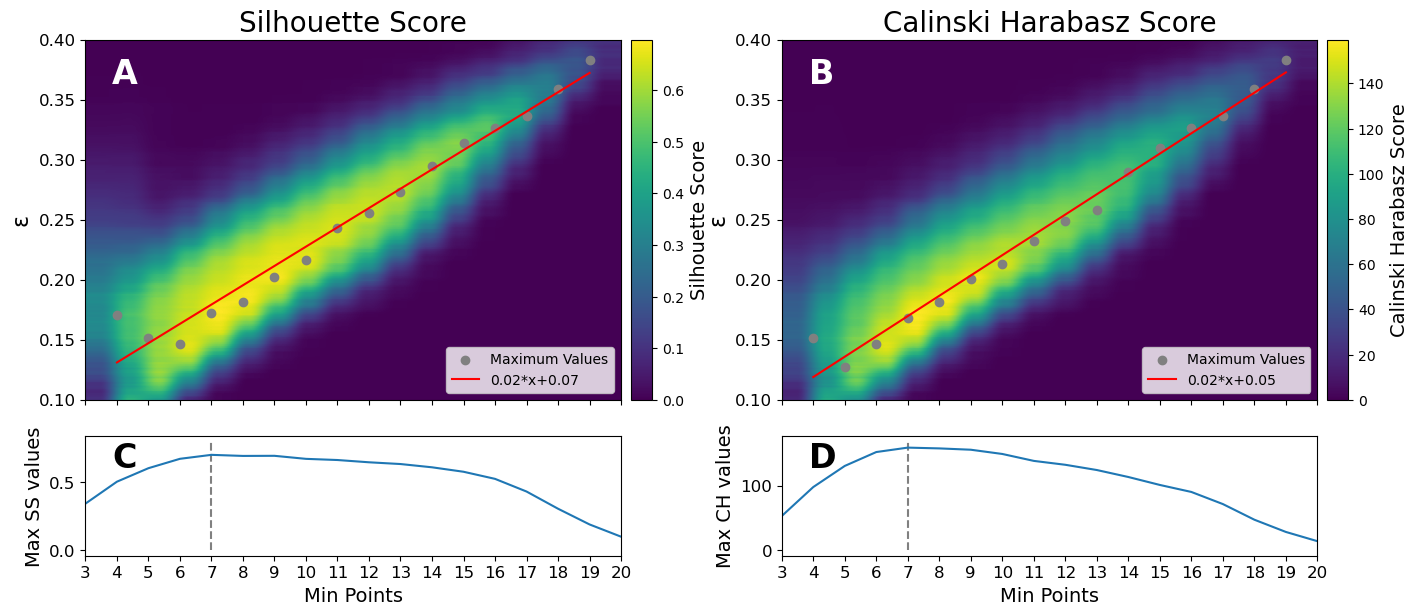

In [301]:
file_path = r"C:\Users\silke\OneDrive\Skrivebord\Thesis\DBSCAN\Save_metric\SS_save.pkl"
with open(file_path, 'rb') as f:
    SS_save = pickle.load(f)

file_path = r"C:\Users\silke\OneDrive\Skrivebord\Thesis\DBSCAN\Save_metric\CH_save.pkl"
with open(file_path, 'rb') as f:
    CH_save = pickle.load(f)

fig = plt.figure(figsize=(14, 6))
plt.subplots_adjust(wspace=0.3, hspace=0.15, left=0.05, right=0.93, top=0.95, bottom=0.09)

gs = GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[3, 1], wspace=0.3)
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})

# Plot for Silhouette Score
ax1 = plt.subplot(gs[0, 0])
data = np.array([SS_save[f"SS{i}"] for i in range(3, 21)]).T.astype(float) /number_of_bootstraps
img1 = ax1.imshow(data, cmap='viridis', origin='lower', extent=[3, 20, 0.1, 0.4], aspect='auto')
ax1.set_yticks([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4])
ax1.set_ylabel('ε',fontsize = 16)
ax1.set_title('Silhouette Score',fontsize = 20)
plt.setp(ax1.get_xticklabels(), visible=False)

esps_SS = []; max_SS_list = []
for i in range(3, 21):
    SS_array = np.array([SS_save[f"SS{i}"]])
    max_index = np.argmax(SS_array)
    max_SS_list.append(SS_save[f"SS{i}"][max_index])
    esps_SS.append(esps[max_index])

x_values_SS = list(range(4, 20))
y_values_SS = esps_SS[1:-1]
slope_SS, intercept_SS = np.polyfit(x_values_SS, y_values_SS, 1)
ax1.scatter(x_values_SS, y_values_SS, label='Maximum Values', color="grey")
x_fit_SS = np.linspace(min(x_values_SS), max(x_values_SS), 100)
y_fit_SS = slope_SS * x_fit_SS + intercept_SS
ax1.plot(x_fit_SS, y_fit_SS, color='red', label=f'{np.round(slope_SS,2)}*x+{np.round(intercept_SS,2)}')
ax1.legend(loc = 4,facecolor = "white")

# Plot for Calinski Harabasz Score
ax2 = plt.subplot(gs[0, 1], sharex=ax1)
data = np.array([CH_save[f"CH{i}"] for i in range(3, 21)]).T.astype(float)/number_of_bootstraps
img2 = ax2.imshow(data, cmap='viridis', origin='lower', extent=[3, 20, 0.1, 0.4], aspect='auto')
ax2.set_yticks([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4])
ax2.set_ylabel('ε',fontsize = 16)
ax2.set_title('Calinski Harabasz Score',fontsize = 20)
plt.setp(ax2.get_xticklabels(), visible=False)

esps_CH = []
max_CH_list = []
for i in range(3, 21):
    CH_array = np.array([CH_save[f"CH{i}"]])
    max_index = np.argmax(CH_array)
    max_CH_list.append(CH_save[f"CH{i}"][max_index])
    esps_CH.append(esps[max_index])

x_values_CH = list(range(4, 20))
y_values_CH = esps_CH[1:-1]
slope_CH, intercept_CH = np.polyfit(x_values_CH, y_values_CH, 1)
ax2.scatter(x_values_CH, y_values_CH, label='Maximum Values', color="grey")
x_fit_CH = np.linspace(min(x_values_CH), max(x_values_CH), 100)
y_fit_CH = slope_CH * x_fit_CH + intercept_CH
ax2.plot(x_fit_CH, y_fit_CH, color='red', label=f'{np.round(slope_CH,2)}*x+{np.round(intercept_CH,2)}')
ax2.legend(loc = 4,facecolor = "white")

# Plot for Max SS values
ax3 = plt.subplot(gs[1, 0], sharex=ax1)
ax3.vlines(7,0,max(max_SS_list)/number_of_bootstraps+0.1,color = "0.5",linestyle = "dashed")

ax3.plot(list(range(3, 21)), np.array(max_SS_list)/number_of_bootstraps)
ax3.set_xticks(np.arange(3, 21, 1))
ax3.set_xticklabels([f"{i}" for i in range(3, 21)])
ax3.set_xlabel('Min Points',fontsize = 14)
ax3.set_ylabel('Max SS values',fontsize = 14)

# Plot for Max CH values
ax4 = plt.subplot(gs[1, 1], sharex=ax2)  # Share x-axis with ax2
ax4.vlines(7,0,max(max_CH_list)/number_of_bootstraps+10,color = "0.5",linestyle = "dashed")

img4 = ax4.plot(list(range(3, 21)), np.array(max_CH_list)/number_of_bootstraps)
ax4.set_xticks(np.arange(3, 21, 1))
ax4.set_xticklabels([f"{i}" for i in range(3, 21)])
ax4.set_xlabel('Min Points',fontsize = 14)
ax4.set_ylabel('Max CH values',fontsize = 14)


ax1.tick_params(labelsize = 12)
ax2.tick_params(labelsize = 12)
ax3.tick_params(labelsize = 12)
ax4.tick_params(labelsize = 12)

cbar_ax1 = fig.add_axes([0.44, 0.35, 0.015, 0.6])  # [left, bottom, width, height]
cbar1 = fig.colorbar(img1, cax=cbar_ax1, orientation='vertical')
cbar1.set_label('Silhouette Score',fontsize = 14)

cbar_ax2 = fig.add_axes([0.937, 0.35, 0.015, 0.6])  # [left, bottom, width, height]
cbar2 = fig.colorbar(img2, cax=cbar_ax2, orientation='vertical')
cbar2.set_label('Calinski Harabasz Score',fontsize = 14)
    
ax1.text(0.05, 0.95, "A", transform=ax1.transAxes, fontsize=24, color = "white", fontweight='bold', va='top', ha='left')
ax2.text(0.05, 0.95, "B", transform=ax2.transAxes, fontsize=24, color = "white", fontweight='bold', va='top', ha='left')
ax3.text(0.05, 0.95, "C", transform=ax3.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax4.text(0.05, 0.95, "D", transform=ax4.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
image_name = os.path.join(folder_path, 'GridSearch.png')
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=300)

In [302]:
esps_CH_max = np.argmax(CH_save["CH7"])
esps_SS_max = np.argmax(SS_save["SS7"])
print(esps_CH_max,esps_SS_max)

45 48


In [303]:
DBSCAN(eps=esps[esps_SS_max], min_samples=7)

DBSCAN(eps=0.17236180904522613, min_samples=7)

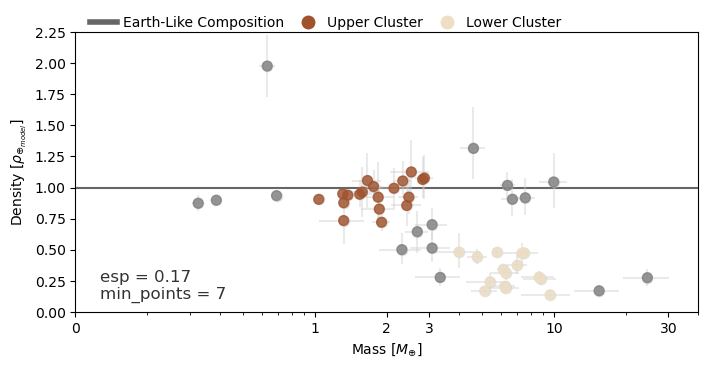

In [304]:
fig, axes = plt.subplots(1,1, figsize=(7,3.5))
plt.subplots_adjust(wspace=0.05, hspace=0.095, left=0.10, right=0.99, top=0.93, bottom=0.13)

ax = axes
ax.errorbar(mass, density,xerr = mass_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
i = 6
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=esps[esps_SS_max], min_samples=7)
labels = dbscan.fit_predict(df)
DBSCAN_labels = labels
label_list   = []; mass_list    = []; density_list = []
colorlist = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
ax.scatter(mass,df['Density_norm'], c=labels, cmap = custom_cmap2, s=50, alpha=0.8)
silhouette = silhouette_score(dfs, label_list)

ax.set_ylabel("Density $[ρ_{ \oplus_{model}}]$")
ax.plot(earth_like_rocky["Mass"],np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = earth,label = "Earth-Like Composition",zorder = -50)
ax.plot(100,100,".",color = rocky,label = "Upper Cluster",zorder = -50,markersize = 18)
ax.plot(100,100,".",color = puffy,label = "Lower Cluster",zorder = -50,markersize = 18)
ax.set_xlim(0.1, 40)
ax.set_ylim(0, 2.25)
ax.set_xscale('log')
ax.set_xlabel("Mass [$M_{\oplus}]$")
ax.set_ylabel("Density $[ρ_{ \oplus_{model}}]$")
ax.text(0.04, 0.15, "esp = 0.17", transform=ax.transAxes, fontsize=12, fontweight='light', va='top', ha='left',alpha = 0.8)
ax.text(0.04, 0.09, "min_points = 7", transform=ax.transAxes, fontsize=12, fontweight='light', va='top', ha='left',alpha = 0.8)

ax.set_xticks([0.1, 1, 2,3, 10,30])  # Setting x-axis ticks for ax2
ax.xaxis.set_major_formatter(FuncFormatter(format_func))

leg = ax.legend(bbox_to_anchor=(0.8, 1.104), frameon=False,handletextpad=0.4,fontsize = 10,ncol = 3,columnspacing = 0.7)
for line in leg.get_lines():
    line.set_linewidth(4.0)   
folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
image_name = os.path.join(folder_path, 'DBSCAN_bestfit.png')
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=300)

In [ ]:
esps   = np.linspace(0.1,0.4,200)
esps_CH_max = np.argmax(CH_save["CH5"])
esps_SS_max = np.argmax(SS_save["SS5"])
print(esps_CH_max,esps_SS_max)

In [ ]:
esps_CH_max = np.argmax(CH_save["CH11"])
esps_SS_max = np.argmax(SS_save["SS11"])
plt.plot(esps,CH_save["CH11"]/300,".")
plt.plot(esps,SS_save["SS11"],".")
print(esps_CH_max,esps_SS_max)
plt.vlines(esps[esps_SS_max],0,140)
plt.grid()

In [ ]:
esps[95]

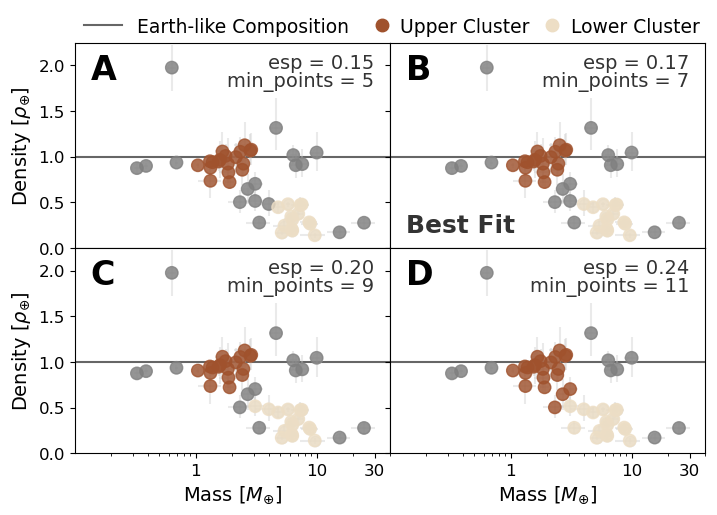

In [325]:
fig, axes = plt.subplots(2,2, figsize=(7,5), sharex=True,sharey=True)
plt.subplots_adjust(wspace=0, hspace=0, left=0.09, right=0.99, top=0.92, bottom=0.099)

esps   = np.linspace(0.1,0.4,200)

ax1 = axes[0,0]; ax2 = axes[0,1]; 
ax3 = axes[1,0]; ax4 = axes[1,1];


# Add subplot A
ax1.errorbar(mass, density,xerr = mass_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(esps[34], min_samples=5)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
colorlist = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
ax1.scatter(mass,df['Density_norm'], c=labels, cmap = custom_cmap2, s=80, alpha=0.8)
earth_line = ax1.plot(earth_like_rocky["Mass"],np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = earth,label = "Earth-like Composition",zorder = -50)

# Add subplot B
ax2.errorbar(mass, density,xerr = mass_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=esps[48], min_samples=7)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
colorlist = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
ax2.scatter(mass,df['Density_norm'], c=labels, cmap = custom_cmap2, s=80, alpha=0.8)
ax2.plot(earth_like_rocky["Mass"],np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = earth,label = "Earth-like",zorder = -50)

# Add subplot C
ax3.errorbar(mass, density,xerr = mass_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=esps[68], min_samples=9)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
colorlist = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
ax3.scatter(mass,df['Density_norm'], c=labels, cmap = custom_cmap2, s=80, alpha=0.8)
ax3.plot(earth_like_rocky["Mass"],np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = earth,label = "Earth-like",zorder = -50)

# Add subplot D
ax4.errorbar(mass, density,xerr = mass_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=esps[98], min_samples=11)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
colorlist = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
ax4.scatter(mass,df['Density_norm'], c=labels, cmap = custom_cmap2, s=80, alpha=0.8)
ax4.plot(earth_like_rocky["Mass"],np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = earth,label = "Earth-like",zorder = -50)


ax1.set_xlim(0.1, 40)
ax1.set_ylim(0, 2.25)
ax1.set_xscale('log')

ax1.set_xticks([1, 10,30])  # Setting x-axis ticks for ax2
ax1.xaxis.set_major_formatter(FuncFormatter(format_func))

ax3.set_xlabel("Mass [$M_{\oplus}]$",fontsize = 14)
ax4.set_xlabel("Mass [$M_{\oplus}]$",fontsize = 14)

ax1.set_ylabel("Density $[ρ_{\oplus}]$",fontsize = 14)
ax3.set_ylabel("Density $[ρ_{\oplus}]$",fontsize = 14)

ax1.text(0.95, 0.95, "esp = 0.15", transform=ax1.transAxes, fontsize=14, fontweight='light', va='top', ha='right',alpha = 0.8)
ax2.text(0.95, 0.95, "esp = 0.17", transform=ax2.transAxes, fontsize=14, fontweight='light', va='top', ha='right',alpha = 0.8)
ax3.text(0.95, 0.95, "esp = 0.20", transform=ax3.transAxes, fontsize=14, fontweight='light', va='top', ha='right',alpha = 0.8)
ax4.text(0.95, 0.95, "esp = 0.24", transform=ax4.transAxes, fontsize=14, fontweight='light', va='top', ha='right',alpha = 0.8)

ax2.text(0.05, 0.05, "Best Fit", transform=ax2.transAxes, fontsize=18, fontweight='bold', va='bottom', ha='left',alpha = 0.8)

ax1.text(0.95, 0.86, "min_points = 5", transform=ax1.transAxes, fontsize=14, fontweight='light', va='top', ha='right',alpha = 0.8)
ax2.text(0.95, 0.86, "min_points = 7", transform=ax2.transAxes, fontsize=14, fontweight='light', va='top', ha='right',alpha = 0.8)
ax3.text(0.95, 0.86, "min_points = 9", transform=ax3.transAxes, fontsize=14, fontweight='light', va='top', ha='right',alpha = 0.8)
ax4.text(0.95, 0.86, "min_points = 11", transform=ax4.transAxes, fontsize=14, fontweight='light', va='top', ha='right',alpha = 0.8)


ax1.tick_params(labelsize = 12)
ax2.tick_params(labelsize = 12)
ax3.tick_params(labelsize = 12)
ax4.tick_params(labelsize = 12)

ax1.text(0.05, 0.95, "A", transform=ax1.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax2.text(0.05, 0.95, "B", transform=ax2.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax3.text(0.05, 0.95, "C", transform=ax3.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax4.text(0.05, 0.95, "D", transform=ax4.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

upper = ax1.plot(100,100,".",color = rocky,label = "Upper Cluster",zorder = -50,markersize = 18)
lower = ax1.plot(100,100,".",color = puffy,label = "Lower Cluster",zorder = -50,markersize = 18)
ax1.legend(handles=[earth_line[0]],bbox_to_anchor=(0.45, 1.08), loc='center', frameon=False,handletextpad=0.8,fontsize = 13.5)
ax2.legend(handles=[upper[0],lower[0]], bbox_to_anchor=(0.45, 1.08), loc='center',columnspacing = 0.2,frameon=False, ncol=2,handletextpad=0.000001,fontsize = 13.5)

folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
image_name = os.path.join(folder_path, 'DBSCAN_grid.png')
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=300)

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(7,5), sharex=True,sharey=True)
plt.subplots_adjust(wspace=0, hspace=0, left=0.1, right=0.99, top=0.95, bottom=0.1)

esps   = np.linspace(0.1,0.4,200)

ax1 = axes[0,0]; ax2 = axes[0,1]; ax3 = axes[0,2]; 
ax4 = axes[1,0]; ax5 = axes[1,1]; ax6 = axes[1,2]; 
ax7 = axes[2,0]; ax8 = axes[2,1]; ax9 = axes[2,2]; 

# Add subplot A
ax1.errorbar(mass, density,xerr = mass_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(esps[2], min_samples=4)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
colorlist = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
ax1.scatter(mass,df['Density_norm'], c=labels, cmap = custom_cmap2, s=50, alpha=0.8)
ax1.plot(earth_like_rocky["Mass"],np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = earth,label = "Earth-like",zorder = -50)

# Add subplot B
ax2.errorbar(mass, density,xerr = mass_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=esps[36], min_samples=5)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
colorlist = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
ax2.scatter(mass,df['Density_norm'], c=labels, cmap = custom_cmap2, s=50, alpha=0.8)
ax2.plot(earth_like_rocky["Mass"],np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = earth,label = "Earth-like",zorder = -50)

# Add subplot C
ax3.errorbar(mass, density,xerr = mass_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=esps[39], min_samples=6)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
colorlist = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
ax3.scatter(mass,df['Density_norm'], c=labels, cmap = custom_cmap2, s=50, alpha=0.8)
ax3.plot(earth_like_rocky["Mass"],np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = earth,label = "Earth-like",zorder = -50)

# Add subplot D
ax4.errorbar(mass, density,xerr = mass_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=esps[52], min_samples=7)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
colorlist = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
ax4.scatter(mass,df['Density_norm'], c=labels, cmap = custom_cmap2, s=50, alpha=0.8)
ax4.plot(earth_like_rocky["Mass"],np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = earth,label = "Earth-like",zorder = -50)

# Add subplot F
ax5.errorbar(mass, density,xerr = mass_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=esps[67], min_samples=8)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
colorlist = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
ax5.scatter(mass,df['Density_norm'], c=labels, cmap = custom_cmap2, s=50, alpha=0.8)
ax5.plot(earth_like_rocky["Mass"],np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = earth,label = "Earth-like",zorder = -50)

# Add subplot G
ax6.errorbar(mass, density,xerr = mass_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=esps[81], min_samples=9)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
colorlist = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
ax6.scatter(mass,df['Density_norm'], c=labels, cmap = custom_cmap2, s=50, alpha=0.8)
ax6.plot(earth_like_rocky["Mass"],np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = earth,label = "Earth-like",zorder = -50)

# Add subplot G
ax7.errorbar(mass, density,xerr = mass_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=esps[88], min_samples=10)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
colorlist = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
ax7.scatter(mass,df['Density_norm'], c=labels, cmap = custom_cmap2, s=50, alpha=0.8)
ax7.plot(earth_like_rocky["Mass"],np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = earth,label = "Earth-like",zorder = -50)

# Add subplot G
ax8.errorbar(mass, density,xerr = mass_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=esps[97], min_samples=11)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
colorlist = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
ax8.scatter(mass,df['Density_norm'], c=labels, cmap = custom_cmap2, s=50, alpha=0.8)
ax8.plot(earth_like_rocky["Mass"],np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = earth,label = "Earth-like",zorder = -50)

# Add subplot H
ax9.errorbar(mass, density,xerr = mass_err, yerr = density_err,fmt='.',markersize = 15,color = "0.8",zorder=-32,alpha = 0.4)
df = pd.DataFrame({'Mass10': mass10, 'Density_norm': density})
dbscan = DBSCAN(eps=esps[121], min_samples=12)
labels = dbscan.fit_predict(df)
label_list   = []; mass_list    = []; density_list = []
colorlist = []
for i in range(0,len(mass10)):
    if labels[i] != -1:
        label_list.append(labels[i]); mass_list.append(mass[i]); density_list.append(density[i])
        dfs = pd.DataFrame({'Mass_list': mass_list, 'density_list': density_list})
ax9.scatter(mass,df['Density_norm'], c=labels, cmap = custom_cmap2, s=50, alpha=0.8)
earth_line = ax9.plot(earth_like_rocky["Mass"],np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = earth,label = "Earth-Like Composition",zorder = -50)


ax1.set_xlim(0.1, 40)
ax1.set_ylim(0, 2.25)
ax1.set_xscale('log')

ax7.set_xticks([1, 10,30])  # Setting x-axis ticks for ax2
ax7.xaxis.set_major_formatter(FuncFormatter(format_func))


ax7.set_xlabel("Mass [$M_{\oplus}]$")
ax8.set_xlabel("Mass [$M_{\oplus}]$")
ax9.set_xlabel("Mass [$M_{\oplus}]$")

ax1.set_ylabel("Density $[ρ_{\oplus}]$")
ax4.set_ylabel("Density $[ρ_{\oplus}]$")
ax7.set_ylabel("Density $[ρ_{\oplus}]$")

ax1.text(0.42, 0.98, "esp = 0.103", transform=ax1.transAxes, fontsize=10, fontweight='light', va='top', ha='left',alpha = 0.8)
ax2.text(0.42, 0.98, "esp = 0.154", transform=ax2.transAxes, fontsize=10, fontweight='light', va='top', ha='left',alpha = 0.8)
ax3.text(0.42, 0.98, "esp = 0.159", transform=ax3.transAxes, fontsize=10, fontweight='light', va='top', ha='left',alpha = 0.8)
ax4.text(0.42, 0.98, "esp = 0.178", transform=ax4.transAxes, fontsize=10, fontweight='light', va='top', ha='left',alpha = 0.8)
ax5.text(0.42, 0.98, "esp = 0.201", transform=ax5.transAxes, fontsize=10, fontweight='light', va='top', ha='left',alpha = 0.8)
ax6.text(0.42, 0.98, "esp = 0.222", transform=ax6.transAxes, fontsize=10, fontweight='light', va='top', ha='left',alpha = 0.8)
ax7.text(0.42, 0.98, "esp = 0.233", transform=ax7.transAxes, fontsize=10, fontweight='light', va='top', ha='left',alpha = 0.8)
ax8.text(0.42, 0.98, "esp = 0.246", transform=ax8.transAxes, fontsize=10, fontweight='light', va='top', ha='left',alpha = 0.8)
ax9.text(0.42, 0.98, "esp = 0.282", transform=ax9.transAxes, fontsize=10, fontweight='light', va='top', ha='left',alpha = 0.8)


ax1.text(0.42, 0.89, "min_points = 4", transform=ax1.transAxes, fontsize=10, fontweight='light', va='top', ha='left',alpha = 0.8)
ax2.text(0.42, 0.89, "min_points = 5", transform=ax2.transAxes, fontsize=10, fontweight='light', va='top', ha='left',alpha = 0.8)
ax3.text(0.42, 0.89, "min_points = 6", transform=ax3.transAxes, fontsize=10, fontweight='light', va='top', ha='left',alpha = 0.8)
ax4.text(0.42, 0.89, "min_points = 7", transform=ax4.transAxes, fontsize=10, fontweight='light', va='top', ha='left',alpha = 0.8)
ax5.text(0.42, 0.89, "min_points = 8", transform=ax5.transAxes, fontsize=10, fontweight='light', va='top', ha='left',alpha = 0.8)
ax6.text(0.42, 0.89, "min_points = 9", transform=ax6.transAxes, fontsize=10, fontweight='light', va='top', ha='left',alpha = 0.8)
ax7.text(0.42, 0.89, "min_points = 10", transform=ax7.transAxes, fontsize=10, fontweight='light', va='top', ha='left',alpha = 0.8)
ax8.text(0.42, 0.89, "min_points = 11", transform=ax8.transAxes, fontsize=10, fontweight='light', va='top', ha='left',alpha = 0.8)
ax9.text(0.42, 0.89, "min_points = 12", transform=ax9.transAxes, fontsize=10, fontweight='light', va='top', ha='left',alpha = 0.8)


upper = ax1.plot(100,100,".",color = rocky,label = "Upper Cluster",zorder = -50,markersize = 18)
lower = ax1.plot(100,100,".",color = puffy,label = "Lower Cluster",zorder = -50,markersize = 18)
ax1.legend(handles=[earth_line[0]], bbox_to_anchor=(1.05, 1.25), frameon=False, ncol=3,handletextpad=0.8,fontsize = 10)
ax2.legend(handles=[upper[0],lower[0]], bbox_to_anchor=(1.5, 1.25), frameon=False, ncol=2,handletextpad=0.01,fontsize = 10)

folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
image_name = os.path.join(folder_path, 'DBSCAN_grid.png')
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=300)

## KMeans

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
plt.subplot(1, 2, 1)
X = np.column_stack((mass10, density))
n_clusters = 2
ax = axes[0]

kmeans = KMeans(n_clusters=n_clusters, random_state=0,n_init = 10)
kmeans.fit(X)

cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.8,s=80)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', marker='x', s=130, label='Cluster Centers',zorder = 3)
plt.xlim(-0.75,1.5)
plt.ylim(0,2.25)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth Composition",zorder = -18)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.text(0.05, 0.95, "A", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

plt.subplot(1, 2, 2)
X = np.column_stack((mass10, density))
n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=0,n_init = 10)
kmeans.fit(X)

cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_
ax = axes[1]
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.8,s=80)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', marker='x', s=130, label='Cluster Centers',zorder = 3)
plt.xlim(-0.75,1.5)
plt.ylim(0,2.25)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth Composition",zorder = -18)
plt.text(0.05, 0.95, "B", transform=plt.gca().transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)

folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
image_name = os.path.join(folder_path, 'Kmeans_2024sample.png')
image_format = 'png'
#fig.savefig(image_name, format=image_format, dpi=1200)

# ExoMDN


In [326]:
all_predictions = pd.read_csv("../Thesis/ExoMDN/All_predictions.txt",delimiter = "\t",header=None)
new_header = ['Planet Name', 'Core', 'Mantle','Water',"Atmosphere"]
all_predictions.columns = new_header
all_predictions.index = list(all_predictions['Planet Name'])
all_predictions = all_predictions.drop('Planet Name', axis=1)
every_5000th_row = all_predictions.iloc[::5000]
every_5000th_row = every_5000th_row.reindex(planet_name)

### Sort planets by core fraction and ready for plotting in ExoMDN

In [327]:
planet_fraction_list = list(all_predictions[5000*i:5000*i+5000]["Core"])
hist, bin_edges = np.histogram(planet_fraction_list, bins=100, density=True)
max_density_index = np.argmax(hist)
mode = (bin_edges[max_density_index] + bin_edges[max_density_index + 1]) / 2
print("Mode of the posterior distribution:", mode)

Mode of the posterior distribution: 0.8517526704072952


In [ ]:
# Define the desired probability mass (credible interval)
probability_mass = 0.68  # You can adjust this value as needed

for i in range(0,len(planet_name)):
    planet_fraction_list = list(all_predictions[5000*i:5000*i+5000]["Core"])
    # Sort the posterior samples
    sorted_samples = np.sort(planet_fraction_list)

    # Compute the cumulative distribution function (CDF)
    cdf = np.cumsum(sorted_samples) / np.sum(sorted_samples)

    # Find the indices corresponding to the probability mass
    lower_index = np.argmax(cdf >= (1 - probability_mass) / 2)
    upper_index = np.argmax(cdf > 1 - (1 - probability_mass) / 2)

    # Calculate HPDI interval
    hpdi_interval = (sorted_samples[lower_index], sorted_samples[upper_index])

    # Compute a histogram of the posterior samples
    hist, bin_edges = np.histogram(planet_fraction_list, bins=100, density=True)

    # Find the bin with the maximum density
    max_density_index = np.argmax(hist)

    # Calculate the mode
    mode = (bin_edges[max_density_index] + bin_edges[max_density_index + 1]) / 2

    print(all_predictions.index[i*5000])
    print("HPDI interval:", hpdi_interval)
    print("Mode of the posterior distribution:", mode)

In [328]:
columns = ['Planet Name', 'Core Mode']

# Create an empty DataFrame
Core_Means = pd.DataFrame(columns=columns)

# Display the empty DataFrame
for i in range(0,len(planet_name)):
    planet_fraction_list = list(all_predictions[5000*i:5000*i+5000]["Core"])
    hist, bin_edges = np.histogram(planet_fraction_list, bins=100, density=True)
    max_density_index = np.argmax(hist)
    mode = (bin_edges[max_density_index] + bin_edges[max_density_index + 1]) / 2
    row_data = [all_predictions.index[5000*i], mode]
    Core_Means.loc[i] = row_data
Sorted_Core_Means = Core_Means.sort_values(by='Core Mode')

In [329]:
planet_list = []
sorted_planet_names = list(Sorted_Core_Means["Planet Name"])
for i in range(0,len(Sorted_Core_Means)):
    index_standard = np.where(planet_name == sorted_planet_names[i])[0][0]
    planet_list.append([mass[index_standard],radius[index_standard],planet_temp[index_standard]])
planet_name_list = {}

items = Sorted_Core_Means["Planet Name"]

# Use a for loop to add items to the dictionary with keys
for i, item in enumerate(items):
    planet_name_list[i] = item
    
file_path = "../Thesis/ExoMDN/planet_list_MDN.pkl"
with open(file_path, 'wb') as f:
    pickle.dump(planet_list, f)
    
file_path ="../Thesis/ExoMDN/planet_name_list_MDN.pkl"
with open(file_path, 'wb') as f:
    pickle.dump(planet_name_list, f)

IndexError: index 0 is out of bounds for axis 0 with size 0

### Mains

In [330]:
file_path = "../Thesis/ExoMDN/prediction_9april.pkl"
with open(file_path, 'rb') as f:
    prediction = pickle.load(f)
    
selected_columns = ['prediction', 'core_rf', 'mantle_rf', 'water_rf', 'atmosphere_rf']
prediction = prediction[selected_columns]
new_header = ['Name', 'Core', 'Mantle','Water',"Atmosphere"]
prediction.columns = new_header
prediction.index = list(prediction['Name'])
prediction = prediction.drop('Name', axis=1)

1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

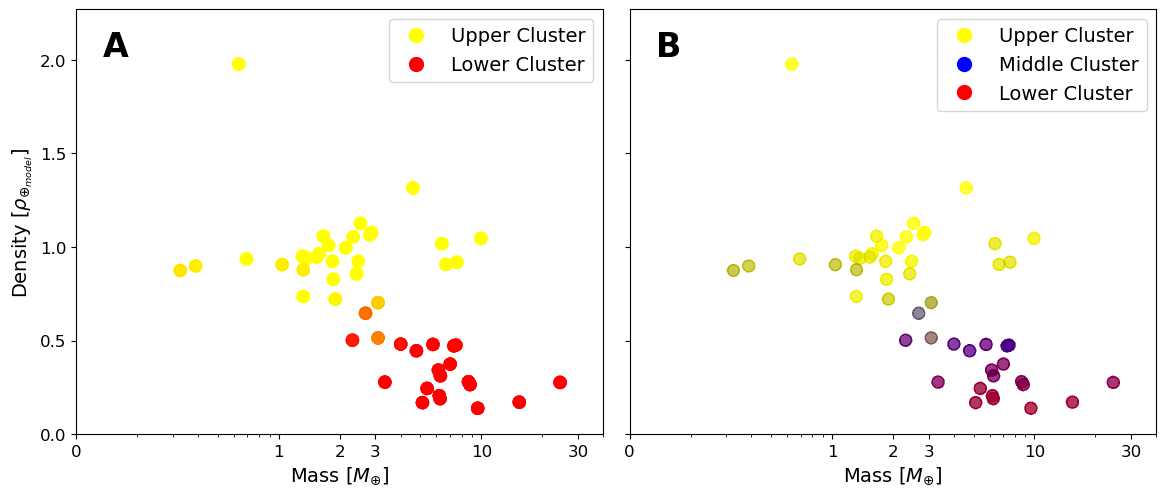

In [333]:
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True, sharex = True)
plt.subplots_adjust(wspace=0.05, hspace=0.1, left=0.08, right=0.98, top=0.95, bottom=0.1)
ax1 = axes[0]
ax2 = axes[1]

def format_func(value, tick_number):
    return int(value)

file_path = "../Thesis/ExoMDN/prediction_9april.pkl"
with open(file_path, 'rb') as f:
    prediction = pickle.load(f)
    
selected_columns = ['prediction', 'core_rf', 'mantle_rf', 'water_rf', 'atmosphere_rf']
prediction = prediction[selected_columns]
new_header = ['Name', 'Core', 'Mantle','Water',"Atmosphere"]
prediction.columns = new_header
prediction.index = list(prediction['Name'])
prediction = prediction.drop('Name', axis=1)

every_5000th_row = prediction.iloc[::5000]
every_5000th_row = every_5000th_row.reindex(planet_name)
X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))

number_of_runs = 100
np.random.seed(42)
random_numbers = np.random.choice(5000, number_of_runs, replace=False)

# Subplot A
label_list2 = []

for k in range(0,number_of_runs):
    random_index = random_numbers[k]
    every_5000th_row = prediction.iloc[random_index::5000]
    #every_5000th_row = every_5000th_row.reindex(planet_name)
    X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))
    kmeans = KMeans(n_clusters=2)
    labels = kmeans.fit_predict(X)
    indices_label_0 = np.where(labels == 0); cluster_0_mean = np.mean(density[indices_label_0])
    indices_label_1 = np.where(labels == 1); cluster_1_mean = np.mean(density[indices_label_1])
    means_dict = {'0': cluster_0_mean, '1': cluster_1_mean}

    # Find the variable with the smallest mean value
    min_variable = int(min(means_dict, key=means_dict.get))
    max_variable = int(max(means_dict, key=means_dict.get))
    new_labels = list(np.zeros(len(planet_name)))

    for i in range(len(planet_name)):
        if labels[i] == min_variable:
            new_labels[i] = 1
        if labels[i] == max_variable:
            new_labels[i] = 2
    ax1.scatter(mass, density, c=new_labels, s= 75, alpha = 0.03, cmap=custom_cmap2pop,edgecolor=None) # min 0.002
    if k != 0 and k % 10 == 0:
        print(int(k/10), end=", ")
    label_list2.append(new_labels)
    
# Subplot B
label_list3 = []
for k in range(0,number_of_runs):
    random_index = random_numbers[k]
    every_5000th_row = prediction.iloc[random_index::5000]
    every_5000th_row = every_5000th_row.reindex(planet_name)
    X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))
    #X = np.column_stack((np.log(every_5000th_row['Mantle']/every_5000th_row['Core']), np.log(every_5000th_row['Water']/every_5000th_row['Core']),np.log(every_5000th_row['Atmosphere']/every_5000th_row['Core'])))

    kmeans = KMeans(n_clusters=3)
    labels = kmeans.fit_predict(X)
    indices_label_0 = np.where(labels == 0); cluster_0_mean = np.mean(density[indices_label_0])
    indices_label_1 = np.where(labels == 1); cluster_1_mean = np.mean(density[indices_label_1])
    indices_label_2 = np.where(labels == 2); cluster_2_mean = np.mean(density[indices_label_2])
    means_dict = {'0': cluster_0_mean, '1': cluster_1_mean, '2': cluster_2_mean}

    # Find the variable with the smallest mean value
    min_variable = int(min(means_dict, key=means_dict.get))
    max_variable = int(max(means_dict, key=means_dict.get))
    mid_variable = (set([0,1,2]) - set([min_variable,max_variable])).pop()
    new_labels = list(np.zeros(len(planet_name)))

    for i in range(len(planet_name)):
        if labels[i] == min_variable:
            new_labels[i] = 2
        if labels[i] == mid_variable:
            new_labels[i] = 0
        if labels[i] == max_variable:
            new_labels[i] = 1
    ax2.scatter(mass, density, c=new_labels, s= 75, alpha = 0.01, cmap=custom_cmap,edgecolor=None) # min 0.002
    if k != 0 and k % 10 == 0:
        print(int(k/10), end=", ")
    label_list3.append(new_labels)

# Legends and axis: 
ax1.plot(100,100,".",color= "yellow",label = "Upper Cluster",markersize=20)
ax1.plot(100,100,"r.",label = "Lower Cluster",markersize=20)

ax2.plot(100,100,".",color= "yellow",label = "Upper Cluster",markersize=20)
ax2.plot(100,100,"b.",label = "Middle Cluster",markersize=20)
ax2.plot(100,100,"r.",label = "Lower Cluster",markersize=20)

ax1.set_xlim(0.1, 40)
ax1.set_ylim(0, 2.27)
ax2.set_xlim(0.1, 40)
ax2.set_ylim(0, 2.27)
ax1.set_xscale("log")
ax2.set_xscale("log")

# Set labels for both axes
ax1.set_xlabel("Mass [$M_{\oplus}]$",fontsize = 14) 
ax2.set_xlabel("Mass [$M_{\oplus}]$",fontsize = 14) 
ax1.set_ylabel("Density $[ρ_{ \oplus_{model}}]$",fontsize = 14)

# Set ticks and tick formatters for both axes
ax1.set_xticks([0.1, 1, 2, 3, 10, 30])
ax2.set_xticks([0.1, 1, 2, 3, 10, 30])
ax2.xaxis.set_major_formatter(FuncFormatter(format_func))
ax1.xaxis.set_major_formatter(FuncFormatter(format_func))

# Show both major and minor ticks for both axes
ax1.tick_params(bottom=True, which='both',labelsize = 12)
ax2.tick_params(bottom=True, which='both',labelsize = 12)

# Add legends to both subplots
ax1.legend(facecolor="white",fontsize = 14)
ax2.legend(facecolor="white",fontsize = 14)

# Add annotations
ax1.text(0.05, 0.95, "A", transform=ax1.transAxes, fontsize=24, fontweight="bold", va="top", ha="left")
ax2.text(0.05, 0.95, "B", transform=ax2.transAxes, fontsize=24, fontweight="bold", va="top", ha="left")

folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
image_name = os.path.join(folder_path, 'KMeans_Exomdn.png')
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=300)

1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

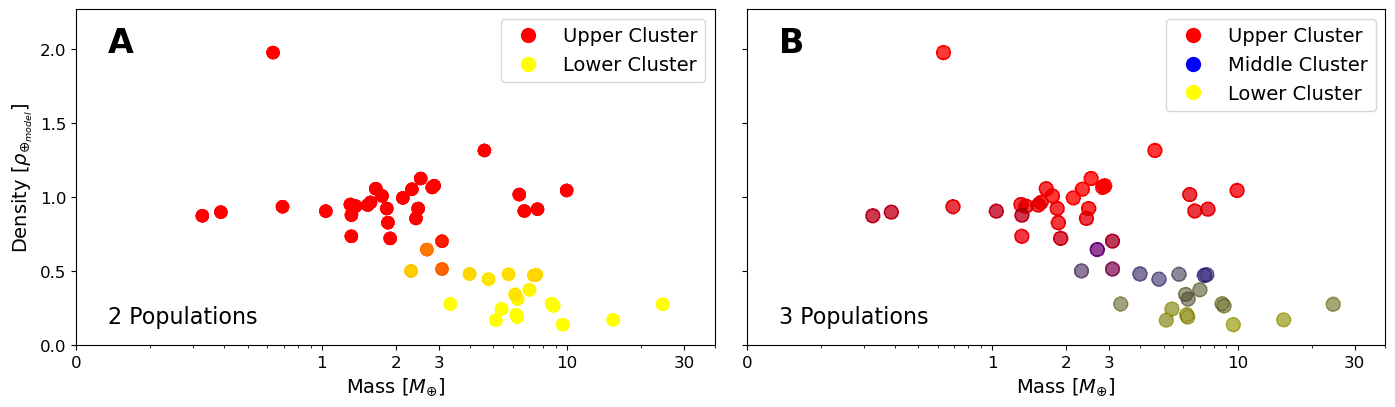

In [348]:
fig, axes = plt.subplots(1, 2, figsize=(14,4), sharey=True, sharex = True)
plt.subplots_adjust(wspace=0.05, hspace=0.1, left=0.055, right=0.99, top=0.99, bottom=0.15)
ax1 = axes[0]
ax2 = axes[1]

def format_func(value, tick_number):
    return int(value)

file_path = "../Thesis/ExoMDN/prediction_9april.pkl"
with open(file_path, 'rb') as f:
    prediction = pickle.load(f)
    
selected_columns = ['prediction', 'core_rf', 'mantle_rf', 'water_rf', 'atmosphere_rf']
prediction = prediction[selected_columns]
new_header = ['Name', 'Core', 'Mantle','Water',"Atmosphere"]
prediction.columns = new_header
prediction.index = list(prediction['Name'])
prediction = prediction.drop('Name', axis=1)

every_5000th_row = prediction.iloc[::5000]
every_5000th_row = every_5000th_row.reindex(planet_name)
X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))

number_of_runs = 100
np.random.seed(42)
random_numbers = np.random.choice(5000, number_of_runs, replace=False)

# Subplot A
label_list2 = []

for k in range(0,number_of_runs):
    random_index = random_numbers[k]
    every_5000th_row = prediction.iloc[random_index::5000]
    #every_5000th_row = every_5000th_row.reindex(planet_name)
    X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))
    kmeans = KMeans(n_clusters=2)
    labels = kmeans.fit_predict(X)
    indices_label_0 = np.where(labels == 0); cluster_0_mean = np.mean(density[indices_label_0])
    indices_label_1 = np.where(labels == 1); cluster_1_mean = np.mean(density[indices_label_1])
    means_dict = {'0': cluster_0_mean, '1': cluster_1_mean}

    # Find the variable with the smallest mean value
    min_variable = int(min(means_dict, key=means_dict.get))
    max_variable = int(max(means_dict, key=means_dict.get))
    new_labels = list(np.zeros(len(planet_name)))

    for i in range(len(planet_name)):
        if labels[i] == min_variable:
            new_labels[i] = 2
        if labels[i] == max_variable:
            new_labels[i] = 1
    ax1.scatter(mass, density, c=new_labels, s= 75, alpha = 0.03, cmap=custom_cmap2pop,edgecolor=None) # min 0.002
    if k != 0 and k % 10 == 0:
        print(int(k/10), end=", ")
    label_list2.append(new_labels)
    
# Subplot B
label_list3 = []
for k in range(0,number_of_runs):
    random_index = random_numbers[k]
    every_5000th_row = prediction.iloc[random_index::5000]
    every_5000th_row = every_5000th_row.reindex(planet_name)
    X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))
    #X = np.column_stack((np.log(every_5000th_row['Mantle']/every_5000th_row['Core']), np.log(every_5000th_row['Water']/every_5000th_row['Core']),np.log(every_5000th_row['Atmosphere']/every_5000th_row['Core'])))

    kmeans = KMeans(n_clusters=3)
    labels = kmeans.fit_predict(X)
    indices_label_0 = np.where(labels == 0); cluster_0_mean = np.mean(density[indices_label_0])
    indices_label_1 = np.where(labels == 1); cluster_1_mean = np.mean(density[indices_label_1])
    indices_label_2 = np.where(labels == 2); cluster_2_mean = np.mean(density[indices_label_2])
    means_dict = {'0': cluster_0_mean, '1': cluster_1_mean, '2': cluster_2_mean}

    # Find the variable with the smallest mean value
    min_variable = int(min(means_dict, key=means_dict.get))
    max_variable = int(max(means_dict, key=means_dict.get))
    mid_variable = (set([0,1,2]) - set([min_variable,max_variable])).pop()
    new_labels = list(np.zeros(len(planet_name)))

    for i in range(len(planet_name)):
        if labels[i] == min_variable:
            new_labels[i] = 1
        if labels[i] == mid_variable:
            new_labels[i] = 0
        if labels[i] == max_variable:
            new_labels[i] = 2
    ax2.scatter(mass, density, c=new_labels, s= 100, alpha = 0.01, cmap=custom_cmap,edgecolor=None) # min 0.002
    if k != 0 and k % 10 == 0:
        print(int(k/10), end=", ")
    label_list3.append(new_labels)

# Legends and axis: 
ax1.plot(100,100,".",color= "red",label = "Upper Cluster",markersize=20)
ax1.plot(100,100,".",color = "yellow",label = "Lower Cluster",markersize=20)

ax2.plot(100,100,".",color= "red",label = "Upper Cluster",markersize=20)
ax2.plot(100,100,"b.",label = "Middle Cluster",markersize=20)
ax2.plot(100,100,".",color = "yellow",label = "Lower Cluster",markersize=20)

ax1.set_xlim(0.1, 40)
ax1.set_ylim(0, 2.27)
ax2.set_xlim(0.1, 40)
ax2.set_ylim(0, 2.27)
ax1.set_xscale("log")
ax2.set_xscale("log")

# Set labels for both axes
ax1.set_xlabel("Mass [$M_{\oplus}]$",fontsize = 14) 
ax2.set_xlabel("Mass [$M_{\oplus}]$",fontsize = 14) 
ax1.set_ylabel("Density $[ρ_{ \oplus_{model}}]$",fontsize = 14)

# Set ticks and tick formatters for both axes
ax1.set_xticks([0.1, 1, 2, 3, 10, 30])
ax2.set_xticks([0.1, 1, 2, 3, 10, 30])
ax2.xaxis.set_major_formatter(FuncFormatter(format_func))
ax1.xaxis.set_major_formatter(FuncFormatter(format_func))

# Show both major and minor ticks for both axes
ax1.tick_params(bottom=True, which='both',labelsize = 12)
ax2.tick_params(bottom=True, which='both',labelsize = 12)

# Add legends to both subplots
ax1.legend(facecolor="white",fontsize = 14)
ax2.legend(facecolor="white",fontsize = 14)

# Add annotations
ax1.text(0.05, 0.95, "A", transform=ax1.transAxes, fontsize=24, fontweight="bold", va="top", ha="left")
ax2.text(0.05, 0.95, "B", transform=ax2.transAxes, fontsize=24, fontweight="bold", va="top", ha="left")

ax1.text(0.05, 0.05, "2 Populations", transform=ax1.transAxes, fontsize=16, fontweight='normal', va='bottom', ha='left')
ax2.text(0.05, 0.05, "3 Populations", transform=ax2.transAxes, fontsize=16, fontweight='normal', va='bottom', ha='left')

folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
image_name = os.path.join(folder_path, 'KMeans_Exomdn.png')
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=300)

In [ ]:
KNN2_rocky = list(np.zeros(len(planet_name)))
KNN2_puffy = list(np.zeros(len(planet_name)))

KNN3_rocky = list(np.zeros(len(planet_name)))
KNN3_puffy = list(np.zeros(len(planet_name)))
KNN3_water = list(np.zeros(len(planet_name)))


for i in range(number_of_runs):
    for j in range(len(planet_name)):
        if label_list2[i][j] == 2:
            KNN2_rocky[j] += 1
        if label_list2[i][j] == 1:
            KNN2_puffy[j] += 1
            
for i in range(number_of_runs):
    for j in range(len(planet_name)):
        if label_list3[i][j] == 1:
            KNN3_rocky[j] += 1
        if label_list3[i][j] == 2:
            KNN3_puffy[j] += 1
        if label_list3[i][j] == 0:
            KNN3_water[j] += 1
        
KNN2 = pd.DataFrame({'Name': planet_name, 'Rocky': KNN2_rocky, 'Puffy': KNN2_puffy})
KNN3 = pd.DataFrame({'Name': planet_name, 'Rocky': KNN3_rocky, 'Puffy': KNN3_puffy,'Water': KNN3_water})

KNN3_cat = []; KNN2_cat = []

for i in range(len(planet_name)):
    if KNN3["Rocky"][i] > 0.9*number_of_runs:
        KNN3_cat.append(1)
    elif KNN3["Water"][i] > 0.9*number_of_runs:
        KNN3_cat.append(0)
    elif KNN3["Puffy"][i] > 0.9*number_of_runs:
        KNN3_cat.append(2)
    else:
        KNN3_cat.append(-1)

for i in range(len(planet_name)):
    if KNN2["Rocky"][i] > 0.9*number_of_runs:
        KNN2_cat.append(2)
    elif KNN2["Puffy"][i] > 0.9*number_of_runs:
        KNN2_cat.append(1)
    else:
        KNN2_cat.append(-1)
        
KNN2 = pd.DataFrame({'Name': planet_name, 'Rocky': KNN2_rocky, 'Puffy': KNN2_puffy,"Catagory" : KNN2_cat})
KNN3 = pd.DataFrame({'Name': planet_name, 'Rocky': KNN3_rocky, 'Puffy': KNN3_puffy,'Water': KNN3_water})


### Centroids

In [ ]:
fig = plt.figure(figsize=(14, 6))
plt.subplots_adjust(wspace=0.05, hspace=0.1, left=0.05, right=1, top=0.95, bottom=0.05)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

all_predictions = pd.read_csv("../Thesis/ExoMDN/All_predictions.txt",delimiter = "\t",header=None)
new_header = ['Name', 'Core', 'Mantle','Water',"Atmosphere"]
all_predictions.columns = new_header
all_predictions.index = list(all_predictions['Name'])
all_predictions = all_predictions.drop('Name', axis=1)
every_5000th_row = all_predictions.iloc[::5000]
every_5000th_row = every_5000th_row.reindex(planet_name)
X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))

number_of_runs = 100
random_numbers = np.random.choice(5000, number_of_runs, replace=False)
label_list = []

for k in range(0,number_of_runs):
    random_index = random_numbers[k]
    every_5000th_row = all_predictions.iloc[random_index::5000]
    every_5000th_row = every_5000th_row.reindex(planet_name)
    X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))

    kmeans = KMeans(n_clusters=3,init = "k-means++")
    labels = kmeans.fit_predict(X)
    indices_label_0 = np.where(labels == 0); cluster_0_mean = np.mean(density[indices_label_0])
    indices_label_1 = np.where(labels == 1); cluster_1_mean = np.mean(density[indices_label_1])
    indices_label_2 = np.where(labels == 2); cluster_2_mean = np.mean(density[indices_label_2])
    means_dict = {'0': cluster_0_mean, '1': cluster_1_mean, '2': cluster_2_mean}

    min_variable = int(min(means_dict, key=means_dict.get))
    max_variable = int(max(means_dict, key=means_dict.get))
    mid_variable = (set([0,1,2]) - set([min_variable,max_variable])).pop()
    new_labels = list(np.zeros(55))
 
    centroids = kmeans.cluster_centers_
    
    for j in range(55):
        if labels[j] == min_variable:
            new_labels[j] = 2
        elif labels[j] == mid_variable:
            new_labels[j] = 0
        elif labels[j] == max_variable:
            new_labels[j] = 1
    
    # Order Centeroids
    index_first_max_point = new_labels.index(1)
    first_max_point_org_value = labels[index_first_max_point]
    #print("Old value max:",first_max_point_org_value)
    #print("New value max:",1)

    index_first_mid_point = new_labels.index(0)
    first_mid_point_org_value = labels[index_first_mid_point]
    
    #print("Old value mid:",first_mid_point_org_value)
    #print("New value mid:",0)

    index_first_min_point = new_labels.index(2)
    first_min_point_org_value = labels[index_first_min_point]     
    #print("Old value min:",first_min_point_org_value)
    #print("New value min:",2)
        
    centroids_new = np.array([list(centroids[first_mid_point_org_value]) , list(centroids[first_max_point_org_value]) , list(centroids[first_min_point_org_value])])
    ax1.scatter(centroids_new[2, 0], centroids_new[2, 2], centroids_new[2, 3], c='red',  marker = "x",s=80,alpha = 0.7)
    ax1.scatter(centroids_new[0, 0], centroids_new[0, 2], centroids_new[0, 3], c='blue', marker = "x", s=80,alpha = 0.7)
    ax1.scatter(centroids_new[1, 0], centroids_new[1, 2], centroids_new[1, 3], c='yellow',  marker = "x",s=80,alpha = 0.7)

    #ax1.scatter(X[:, 0], X[:, 2], X[:, 3], c=new_labels, cmap=custom_cmap, s=75,alpha = 0.2)
    ax2.scatter(mass10, density, c=new_labels, cmap=custom_cmap, s=100,alpha = 0.03)
    
    if k != 0 and k % 10 == 0:
        print(int(k/10), end=", ")
    label_list.append(new_labels)


ax1.set_title('KMeans Centroids')
ax1.set_xlabel('Core fraction')
ax1.set_ylabel('Water fraction')
ax1.set_zlabel('Atmosphere fraction')
ax1.scatter(10, 10, 10, c='red',  marker = "x",s=80, label='Lower Cluster',alpha = 0.7)
ax1.scatter(10, 10, 10, c='blue', marker = "x", s=80, label='Middle Cluster',alpha = 0.7)
ax1.scatter(10, 10, 10, c='yellow',  marker = "x",s=80, label='Upper Cluster',alpha = 0.7)
ax1.set_xlim(0.2,0.8)
ax1.set_ylim(0.1,0.5)
ax1.set_zlim(0,0.4)
ax1.legend()

ax2.set_xlabel("log10(Mass) [log10($M_{\oplus})]$")
ax2.set_ylabel("Density $[ρ_{ \oplus_{model}}]$")

ax2.set_xlim(-0.75,1.5)
ax2.set_ylim(0,2.25)
ax2.plot(3,3,"b.",label = "Lower Cluster",markersize=20)
ax2.plot(3,3,"r.",label = "Middle Cluster",markersize=20)
ax2.plot(3,3,".",color= "yellow",label = "Upper Cluster",markersize=20)
ax2.set_title('KMeans on ExoMDN predictions')
ax2.legend()


folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
image_name = os.path.join(folder_path, 'ExoMDN_center3.png')
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)

In [ ]:
plt.scatter(mass,density,c = KNN2["Catagory"])

In [ ]:
KNN2

In [ ]:
fig = plt.figure(figsize=(14, 6))
plt.subplots_adjust(wspace=0.05, hspace=0.1, left=0, right=1.4, top=0.99, bottom=0.05)

ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.text2D(0.05, 0.95, "A", transform=ax1.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')
ax2.text2D(0.05, 0.95, "B", transform=ax2.transAxes, fontsize=24, fontweight='bold', va='top', ha='left')

bbox1 = ax1.get_position()
bbox2 = ax2.get_position()
ax1.set_position([bbox1.x0 -0.1, bbox1.y0, bbox1.width, bbox1.height])
ax2.set_position([bbox2.x0 - 0.3, bbox2.y0, bbox2.width, bbox2.height])

all_predictions = pd.read_csv("../Thesis/ExoMDN/All_predictions.txt",delimiter = "\t",header=None)
new_header = ['Name', 'Core', 'Mantle','Water',"Atmosphere"]
all_predictions.columns = new_header
all_predictions.index = list(all_predictions['Name'])
all_predictions = all_predictions.drop('Name', axis=1)
every_5000th_row = all_predictions.iloc[::5000]
every_5000th_row = every_5000th_row.reindex(planet_name)
X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))

number_of_runs = 100
random_numbers = np.random.choice(5000, number_of_runs, replace=False)
label_list = []

for k in range(0,number_of_runs):
    random_index = random_numbers[k]
    every_5000th_row = all_predictions.iloc[random_index::5000]
    every_5000th_row = every_5000th_row.reindex(planet_name)
    X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))

    kmeans = KMeans(n_clusters=2,init = "k-means++")
    labels = kmeans.fit_predict(X)
    indices_label_0 = np.where(labels == 0); cluster_0_mean = np.mean(density[indices_label_0])
    indices_label_1 = np.where(labels == 1); cluster_1_mean = np.mean(density[indices_label_1])
    indices_label_2 = np.where(labels == 2); cluster_2_mean = np.mean(density[indices_label_2])
    means_dict = {'0': cluster_0_mean, '1': cluster_1_mean, '2': cluster_2_mean}

    min_variable = int(min(means_dict, key=means_dict.get))
    max_variable = int(max(means_dict, key=means_dict.get))
    mid_variable = (set([0,1,2]) - set([min_variable,max_variable])).pop()
    new_labels = list(np.zeros(55))
 
    centroids = kmeans.cluster_centers_
    
    for j in range(55):
        if labels[j] == min_variable:
            new_labels[j] = 2
        elif labels[j] == mid_variable:
            new_labels[j] = 0
        elif labels[j] == max_variable:
            new_labels[j] = 1
    
    # Order Centeroids
    index_first_max_point = new_labels.index(1)
    first_max_point_org_value = labels[index_first_max_point]
    #print("Old value max:",first_max_point_org_value)
    #print("New value max:",1)

    index_first_min_point = new_labels.index(2)
    first_min_point_org_value = labels[index_first_min_point]     
    #print("Old value min:",first_min_point_org_value)
    #print("New value min:",2)
        
    centroids_new = np.array([list(centroids[first_min_point_org_value]),list(centroids[first_max_point_org_value]) ])
    ax1.scatter(centroids_new[0, 0], centroids_new[0, 2], centroids_new[0, 3], c='red', marker = "x", s=80,alpha = 0.7)
    ax1.scatter(centroids_new[1, 0], centroids_new[1, 2], centroids_new[1, 3], c='yellow',  marker = "x",s=80,alpha = 0.7)
  
    if k != 0 and k % 10 == 0:
        print(int(k/10), end=", ")
    label_list.append(new_labels)

ax1.set_xlabel('Core fraction')
ax1.set_ylabel('Water fraction')
ax1.set_zlabel('Atmosphere fraction')
ax1.scatter(10, 10, 10, c='red', marker = "x", s=80, label='Lower Cluster',alpha = 0.7)
ax1.scatter(10, 10, 10, c='yellow',  marker = "x",s=80, label='Upper Cluster',alpha = 0.7)
ax1.set_xlim(0.2,0.8)
ax1.set_ylim(0.1,0.5)
ax1.set_zlim(0,0.4)
ax1.legend()

label_list = []
for k in range(0,number_of_runs):
    random_index = random_numbers[k]
    every_5000th_row = all_predictions.iloc[random_index::5000]
    every_5000th_row = every_5000th_row.reindex(planet_name)
    X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))

    kmeans = KMeans(n_clusters=3,init = "k-means++")
    labels = kmeans.fit_predict(X)
    indices_label_0 = np.where(labels == 0); cluster_0_mean = np.mean(density[indices_label_0])
    indices_label_1 = np.where(labels == 1); cluster_1_mean = np.mean(density[indices_label_1])
    indices_label_2 = np.where(labels == 2); cluster_2_mean = np.mean(density[indices_label_2])
    means_dict = {'0': cluster_0_mean, '1': cluster_1_mean, '2': cluster_2_mean}

    min_variable = int(min(means_dict, key=means_dict.get))
    max_variable = int(max(means_dict, key=means_dict.get))
    mid_variable = (set([0,1,2]) - set([min_variable,max_variable])).pop()
    new_labels = list(np.zeros(55))
 
    centroids = kmeans.cluster_centers_
    
    for j in range(55):
        if labels[j] == min_variable:
            new_labels[j] = 2
        elif labels[j] == mid_variable:
            new_labels[j] = 0
        elif labels[j] == max_variable:
            new_labels[j] = 1
    
    # Order Centeroids
    index_first_max_point = new_labels.index(1)
    first_max_point_org_value = labels[index_first_max_point]

    index_first_mid_point = new_labels.index(0)
    first_mid_point_org_value = labels[index_first_mid_point]
    
    index_first_min_point = new_labels.index(2)
    first_min_point_org_value = labels[index_first_min_point]     

    centroids_new = np.array([list(centroids[first_mid_point_org_value]) , list(centroids[first_max_point_org_value]) , list(centroids[first_min_point_org_value])])
    ax2.scatter(centroids_new[2, 0], centroids_new[2, 2], centroids_new[2, 3], c='red',  marker = "x",s=80,alpha = 0.7)
    ax2.scatter(centroids_new[0, 0], centroids_new[0, 2], centroids_new[0, 3], c='blue', marker = "x", s=80,alpha = 0.7)
    ax2.scatter(centroids_new[1, 0], centroids_new[1, 2], centroids_new[1, 3], c='yellow',  marker = "x",s=80,alpha = 0.7)

    if k != 0 and k % 10 == 0:
        print(int(k/10), end=", ")
    label_list.append(new_labels)

ax2.set_xlabel('Core fraction')
ax2.set_ylabel('Water fraction')
ax2.set_zlabel('Atmosphere fraction')
ax2.scatter(10, 10, 10, c='red',  marker = "x",s=80, label='Lower Cluster',alpha = 0.7)
ax2.scatter(10, 10, 10, c='blue', marker = "x", s=80, label='Middle Cluster',alpha = 0.7)
ax2.scatter(10, 10, 10, c='yellow',  marker = "x",s=80, label='Upper Cluster',alpha = 0.7)
ax2.set_xlim(0.2,0.8)
ax2.set_ylim(0.1,0.5)
ax2.set_zlim(0,0.4)
ax2.legend()
folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
image_name = os.path.join(folder_path, 'ExoMDN_centers.png')
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=300)

In [ ]:
colors = ['0.95','0.6', 'sienna', 'lightskyblue',"cornflowerblue"]
custom_cmap2 = ListedColormap(colors)
cmap = plt.get_cmap(custom_cmap2, 5)  # Adjust 'jet' to any other colormap if needed


# Clustering Summery

In [ ]:
df = pd.read_csv("../Thesis/Data/clustering_results.txt", delimiter='\t')
sort_column = 'Name'  # Example column name

df_sorted = df.sort_values(by=[sort_column], key=lambda x: x.map({v: i for i, v in enumerate(planet_order[::-1])}))
matrix    = df_sorted.iloc[:, 1:6].values



In [ ]:
    for j in range(55):
        if labels[j] == min_variable:
            new_labels[j] = 2
        elif labels[j] == mid_variable:
            new_labels[j] = 0
        elif labels[j] == max_variable:
            new_labels[j] = 1
            
Rocky = 0, Water = 1, Puffy = 2, Not in Sample = 3, Outliers = 4

In [ ]:
GMM2New = np.insert(np.array(GMM2), 36, -2)


In [ ]:
DBSCAN_labels

In [ ]:
LP34 = []; LP50 = []; GMM2color = [];  GMM3color = []; DBSCAN = []

GMM2New = np.insert(np.array(GMM2), 36, -2)
GMM3New = np.insert(np.array(GMM3), 36, -2)

other_names = ["LHS 1140 b",'LHS 1140 c' ,'L 168-9 b', 'L 168-9 c', "GJ 3053 b","GJ 3053 c"]
LI_names = planet1 + other_names

for i in range(len(planet_name)):
    if planet_name[i] in LI_names:
        if  water_mass(radius1[i]) < mass1[i]-mass_up1[i] and water_radius(mass1[i]) > radius1[i]+radius_up1[i]:
            LP34.append(0)
        elif  water_radius(mass1[i]) < radius1[i]-np.abs(radius_low1[i]):
            LP34.append(2)
        else:
            LP34.append(1)
    else: 
        LP34.append(3)
        
for i in range(len(planet_name)):
    if  water_mass(radius[i]) < mass[i]-mass_up[i] and water_radius(mass[i]) > radius[i]+radius_up[i]:
        LP50.append(0)
    elif  water_radius(mass[i]) < radius[i]-np.abs(radius_low[i]):
        LP50.append(2)
    else: 
        LP50.append(1) # Puffy
        
for i in range(len(planet_name)):
    if GMM2New[i] == 0:
        GMM2color.append(0)
    elif GMM2New[i] == 1:
        GMM2color.append(2)
    elif GMM2New[i] == -2:
        GMM2color.append(3)
        
for i in range(len(planet_name)):
    if GMM3New[i] == 0:
        GMM3color.append(0)
    elif GMM3New[i] == 2:
        GMM3color.append(2)
    elif GMM3New[i] == 1:
        GMM3color.append(1)
    elif GMM3New[i] == -2:
        GMM3color.append(3)
        
for i in range(len(planet_name)):
    if DBSCAN_labels[i] == 0:
        DBSCAN.append(0)
    elif DBSCAN_labels[i] == 1:
        DBSCAN.append(2)
    elif DBSCAN_labels[i] == -1:
        DBSCAN.append(4)

In [ ]:
fig = plt.figure(figsize=(4,6))
plt.subplots_adjust(wspace=0.05, hspace=0.1, left=0.19, right=0.99, top=0.87, bottom=0.05)

cluster_summery = pd.DataFrame({"Planet Name": planet_name, 'UBC34': LP34, 'UBC50': LP50, 'GMM2': GMM2color, "GMM3": GMM3color, "DBSCAN": DBSCAN})
list1 = list(planet_name)
list2 = planet_order

indices = [list1.index(item) for item in list2 if item in list1]
df_sorted = cluster_summery.loc[indices[::-1]]

df_sorted.set_index('Planet Name', inplace=True)

# Define custom colors
colors = [rocky,water,puffy,"white","0.5"]

# Create ListedColormap
custom_cmap5 = ListedColormap(colors)
plt.imshow(df_sorted.values, cmap=custom_cmap5, aspect='auto',alpha = 0.8)
plt.xticks(range(len(df_sorted.columns)), df_sorted.columns)
plt.yticks(range(len(df_sorted.index)), df_sorted.index,fontsize = 7)

plt.plot(100,100,"-",color = rocky, alpha = 0.8,label = "Upper/Rocky Planets")
plt.plot(100,100,"-",color = water, alpha = 0.8,label = "Middle/Water Planets")
plt.plot(100,100,"-",color = puffy, alpha = 0.8,label = "Lower/Gas Planets")
plt.plot(100,100,"-",color = "0.5", alpha = 0.8,label = "Not in Cluster")
plt.plot(100, 100, "-", color="0.9", alpha=0.8, label="Not Included")

plt.xlim(-0.5,4.5)
plt.ylim(-0.5,49.5)

leg = plt.legend(loc=(-0.12,1.02), frameon=False, ncol=2,handletextpad=0.8,fontsize = 10)
for line in leg.get_lines():
    line.set_linewidth(8.0)
    
for i in range(0,55):
    plt.hlines(0.5+i,-0.5,8,"0.4")
plt.show()
folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

image_name = os.path.join(folder_path, 'Cluster_summery.png')
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(11, 11), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.1, left=0.08, right=0.98, top=0.95, bottom=0.05)

num_points = len(mass10)
colors = np.linspace(0, 1, num_points)  # Generate colors from 0 to 1

plt.subplot(2, 2, 1)
columns = ['Planet Name', 'Core Mode']

Core_Means = pd.DataFrame(columns=columns)
for i in range(0,len(planet_name)):
    planet_fraction_list = list(all_predictions[5000*i:5000*i+5000]["Core"])
    hist, bin_edges = np.histogram(planet_fraction_list, bins=100, density=True)
    max_density_index = np.argmax(hist)
    mode = (bin_edges[max_density_index] + bin_edges[max_density_index + 1]) / 2
    row_data = [all_predictions.index[5000*i], mode]
    Core_Means.loc[i] = row_data
Sorted_Core_Means = Core_Means.sort_values(by='Core Mode')
sort_order = list(Sorted_Core_Means["Planet Name"])[::-1]

all_mass = []; all_density = []

intresting_planets = sort_order[::-1]
for i in range(0,len(intresting_planets)):
    index = list(planet_name).index(intresting_planets[i])
    all_mass.append(mass10[index])
    all_density.append(density[index])
    
plt.scatter(all_mass, all_density, c=colors, cmap='inferno', s= 80,edgecolor = "0.6")
plt.xticks([],"")

plt.xlim(-0.75,1.5)
plt.ylim(0,2.05)
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like",zorder = -50)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.title("Sorted by Core Fraction")

plt.subplot(2, 2, 2)
columns = ['Planet Name', 'Mantle Mode']

# Create an empty DataFrame
Mantle_Means = pd.DataFrame(columns=columns)

# Display the empty DataFrame
for i in range(0,len(planet_name)):
    planet_fraction_list = list(all_predictions[5000*i:5000*i+5000]["Mantle"])
    hist, bin_edges = np.histogram(planet_fraction_list, bins=100, density=True)
    max_density_index = np.argmax(hist)
    mode = (bin_edges[max_density_index] + bin_edges[max_density_index + 1]) / 2
    row_data = [all_predictions.index[5000*i], mode]
    Mantle_Means.loc[i] = row_data
Sorted_Mantle_Means = Mantle_Means.sort_values(by='Mantle Mode')
sort_order = list(Sorted_Mantle_Means["Planet Name"])[::-1]

all_mass = []; all_density = []
intresting_planets = sort_order[::-1]
for i in range(0,len(intresting_planets)):
    index = list(planet_name).index(intresting_planets[i])
    all_mass.append(mass10[index])
    all_density.append(density[index])

plt.scatter(all_mass, all_density, c=colors, cmap='inferno', s= 80,edgecolor = "0.6")
plt.title("Sorted by Mantle Fraction")
plt.xlim(-0.75,1.5)
plt.ylim(0,2.05)
plt.yticks([],"")
plt.xticks([],"")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like",zorder = -50)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.plot(10,10,label = "")

plt.subplot(2, 2, 3)
columns = ['Planet Name', 'Water Mode']
Water_Means = pd.DataFrame(columns=columns)
for i in range(0,len(planet_name)):
    planet_fraction_list = list(all_predictions[5000*i:5000*i+5000]["Water"])
    hist, bin_edges = np.histogram(planet_fraction_list, bins=100, density=True)
    max_density_index = np.argmax(hist)
    mode = (bin_edges[max_density_index] + bin_edges[max_density_index + 1]) / 2
    row_data = [all_predictions.index[5000*i], mode]
    Water_Means.loc[i] = row_data
Sorted_Water_Means = Water_Means.sort_values(by='Water Mode')
sort_order = list(Sorted_Water_Means["Planet Name"])[::-1]

all_mass = []; all_density = []
intresting_planets = sort_order[::-1]
for i in range(0,len(intresting_planets)):
    index = list(planet_name).index(intresting_planets[i])
    all_mass.append(mass10[index])
    all_density.append(density[index])
    
plt.scatter(all_mass, all_density, c=colors, cmap='inferno', s= 80,edgecolor = "0.6")

plt.xlim(-0.75,1.5)
plt.ylim(0,2.05)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.ylabel("Density $[ρ_{ \oplus_{model}}]$")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like",zorder = -50)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.title("Sorted by Water Fraction")


plt.subplot(2, 2, 4)
columns = ['Planet Name', 'Atmosphere Mode']
Atm_Means = pd.DataFrame(columns=columns)
for i in range(0,len(planet_name)):
    planet_fraction_list = list(all_predictions[5000*i:5000*i+5000]["Atmosphere"])
    hist, bin_edges = np.histogram(planet_fraction_list, bins=100, density=True)
    max_density_index = np.argmax(hist)
    mode = (bin_edges[max_density_index] + bin_edges[max_density_index + 1]) / 2
    row_data = [all_predictions.index[5000*i], mode]
    Atm_Means.loc[i] = row_data
Sorted_Atm_Means = Atm_Means.sort_values(by='Atmosphere Mode')
sort_order = list(Sorted_Atm_Means["Planet Name"])[::-1]

all_mass = []; all_density = []
intresting_planets = sort_order[::-1]
for i in range(0,len(intresting_planets)):
    index = list(planet_name).index(intresting_planets[i])
    all_mass.append(mass10[index])
    all_density.append(density[index])
    
plt.scatter(all_mass, all_density, c=colors, cmap='inferno', s= 80,edgecolor = "0.6")
plt.yticks([],"")
plt.xlim(-0.75,1.5)
plt.ylim(0,2.05)
plt.xlabel("log10(Mass) [log10($M_{\oplus})]$")
plt.plot(np.log10(earth_like_rocky["Mass"]),np.array(rocky_density(list(earth_like_rocky["Mass"]))) / np.array(rocky_density(list(earth_like_rocky["Mass"]))),"-",color = "Darkgreen",label = "Earth-like",zorder = -50)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.title("Sorted by Atmosphere Fraction")
fig.subplots_adjust(right=0.87)
cbar_ax = fig.add_axes([0.9, 0.05, 0.02, 0.9])  # [left, bottom, width, height]
cbar = plt.colorbar(cax=cbar_ax)
cbar.set_label('Sorting in fraction')
cbar.set_ticks([0.95,0.05]) 
cbar.set_ticklabels(["Highest", "Lowest"], verticalalignment='center', rotation=90)

folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

image_name = os.path.join(folder_path, 'ExoMDN_density_prediction.png')
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=300)

In [ ]:
file_path = "../Thesis/ExoMDN/prediction_with.pkl"
with open(file_path, 'rb') as f:
    prediction = pickle.load(f)
from scipy.stats import gaussian_kde

bins = np.linspace(0,1,40)
data = {"Planet Name": [], "core_rf": []}
core_frac = pd.DataFrame(data)
for i in range(0,len(planet_name)):
    filtered_data = prediction[prediction["prediction"] == planet_name[i]]
    kde = gaussian_kde(filtered_data["core_rf"])
    x_values = np.linspace(min(filtered_data["core_rf"]), max(filtered_data["core_rf"]), 1000)
    kde_values = kde(x_values)
    max_density_index = np.argmax(kde_values)
    mode = x_values[max_density_index]    
    new_row = pd.DataFrame({"Planet Name": [planet_name[i]], "core_rf": mode})
    core_frac = pd.concat([core_frac, new_row], ignore_index=True)
    core_frac_sorted = core_frac.sort_values(by="core_rf")
planet_order = list(core_frac_sorted["Planet Name"])
prediction["prediction"] = pd.Categorical(prediction["prediction"], categories=planet_order, ordered=True)


## Sort ExoMDN data

In [ ]:
file_path = "../Thesis/ExoMDN/prediction_9april.pkl"
with open(file_path, 'rb') as f:
    prediction = pickle.load(f)
from scipy.stats import gaussian_kde

bins = np.linspace(0,1,40)
data = {"Planet Name": [], "core_rf": []}
core_frac = pd.DataFrame(data)
for i in range(0,len(planet_name)):
    filtered_data = prediction[prediction["prediction"] == planet_name[i]]
    kde = gaussian_kde(filtered_data["core_rf"])
    x_values = np.linspace(min(filtered_data["core_rf"]), max(filtered_data["core_rf"]), 1000)
    kde_values = kde(x_values)
    max_density_index = np.argmax(kde_values)
    mode = x_values[max_density_index]    
    new_row = pd.DataFrame({"Planet Name": [planet_name[i]], "core_rf": mode})
    core_frac = pd.concat([core_frac, new_row], ignore_index=True)
    core_frac_sorted = core_frac.sort_values(by="core_rf")
planet_order = list(core_frac_sorted["Planet Name"])
prediction["prediction"] = pd.Categorical(prediction["prediction"], categories=planet_order, ordered=True)

# Sort the DataFrame by the "prediction" column
prediction_sorted = prediction.sort_values(by="prediction")

In [ ]:
file_path = "../Thesis/ExoMDN/prediction_9april.pkl"
with open(file_path, 'rb') as f:
    prediction = pickle.load(f)
from scipy.stats import gaussian_kde

bins = np.linspace(0,1,40)
data = {"Planet Name": [], "core_rf": []}
core_frac = pd.DataFrame(data)
for i in range(0,len(planet_name)):
    filtered_data = prediction[prediction["prediction"] == planet_name[i]]
    kde = gaussian_kde(filtered_data["core_rf"])
    x_values = np.linspace(min(filtered_data["core_rf"]), max(filtered_data["core_rf"]), 1000)
    kde_values = kde(x_values)
    max_density_index = np.argmax(kde_values)
    mode = x_values[max_density_index]    
    new_row = pd.DataFrame({"Planet Name": [planet_name[i]], "core_rf": mode})
    core_frac = pd.concat([core_frac, new_row], ignore_index=True)
    core_frac_sorted = core_frac.sort_values(by="core_rf")
planet_order = list(core_frac_sorted["Planet Name"])
prediction["prediction"] = pd.Categorical(prediction["prediction"], categories=planet_order, ordered=True)

# Sort the DataFrame by the "prediction" column
prediction_sorted = prediction.sort_values(by="prediction")

# Iterate over the top 5 planet orders
for i in range(5):
    # Filter data for the current planet order
    filtered_data = prediction[prediction["prediction"] == planet_order[i]]
    
    # Compute the KDE of the filtered data
    kde = gaussian_kde(filtered_data["core_rf"])
    
    # Generate a range of x values for plotting
    x_values = np.linspace(0, 1, 1000)
    
    # Evaluate the KDE at the generated x values
    kde_values = kde(x_values)
    
    # Find the mode (peak) of the KDE
    mode = x_values[np.argmax(kde_values)]
    
    # Plot the KDE
    plt.plot(x_values, kde_values, label=f"Planet {planet_order[i]}")
    
    # Plot a vertical line at the mode
    plt.vlines(mode, 0, max(kde_values), color="black", linestyle="--", label=f"Mode: {mode:.2f}")
    
    plt.xlim(0, 1)
    plt.xlabel("core_rf")
    plt.ylabel("Density")
    plt.title("Kernel Density Estimate")
    plt.legend()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Sort the DataFrame by the "prediction" column
prediction_sorted = prediction.sort_values(by="prediction")

# Get the planet order
planet_order = list(prediction_sorted["prediction"].unique())

# Create a figure and axis
fig, ax = plt.subplots()

# Iterate over the top 5 planet orders
for i in range(55):
    # Filter data for the current planet order
    filtered_data = prediction[prediction["prediction"] == planet_order[i]]
    
    # Compute the KDE of the filtered data
    kde = gaussian_kde(filtered_data["core_rf"])
    
    # Generate a range of x values for plotting
    x_values = np.linspace(0, 1, 1000)
    
    # Evaluate the KDE at the generated x values
    kde_values = kde(x_values)
    
    # Plot the KDE with reversed plasma color palette
    plt.plot(x_values, kde_values - i * 1, label=f"Planet {planet_order[i]}", color=plt.cm.plasma_r(i / 54))

# Set plot labels and title
plt.xlabel("core_rf")
plt.ylabel("Density")
plt.title("Kernel Density Estimate")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
matrix[:,-2]
# Define the number of segments
num_segments = 100

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 13))

for i in range(54):
    # Get the planet index from the planet_order list
    planet_index = planet_order[i]

    # Filtered data
    filtered_data = prediction[prediction["prediction"] == planet_index]

    # Compute KDE
    kde = gaussian_kde(filtered_data["core_rf"])

    # Generate x values
    x_values = np.linspace(0, 1, 1000)

    # Compute KDE values
    kde_values = kde(x_values)

    # Generate the segment boundaries
    segment_boundaries = np.linspace(0, 1, num_segments + 1)

    # Divide the x values into segments
    segments = np.digitize(x_values, segment_boundaries)

    # Initialize lists to store segment maximum values and colors
    max_values = []
    # Compute the KDE for each segment and find the maximum value
    for segment in range(1, num_segments + 1):
        segment_indices = np.where(segments == segment)[0]
        segment_kde_values = kde_values[segment_indices]
        max_value = np.max(segment_kde_values)
        max_values.append(max_value)

    # Fill the area under the KDE curve for each segment with a color based on the maximum value in that segment
    for segment in range(1, num_segments + 1):
        segment_indices = np.where(segments == segment)[0]
        segment_kde_values = kde_values[segment_indices]
        color = plt.cm.plasma_r(0.2 + i / 54)
        alpha = (max_values[segment - 1] / np.max(max_values))

# Calculate modified RGB values to increase whiteness
        modified_color = ((1 - alpha) * 1 + alpha * color[0],
                  (1 - alpha) * 1 + alpha * color[1],
                  (1 - alpha) * 1 + alpha * color[2],
                  color[3])
        ax.plot(x_values[segment_indices], segment_kde_values +55- 3 * i, color='0.7', linestyle='-', linewidth=0.75,zorder = i)
        ax.fill_between(x_values[segment_indices], segment_kde_values + 55-3 * i,55-3 * i, color=color,zorder = i)

# Set plot labels and title
ax.set_xlabel(r"$R_{Core} / R_{Planet}$")
ax.set_title("Mantle")
ax.set_xlim(0,1)
ax.set_yticks([])
ax.set_ylim(-106,60)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

In [ ]:
distance = 3
scale = len(planet_name)
def format_func(value, tick_number):
    return float(value)

fig, axes = plt.subplots(1,4, figsize=(12, 6), sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=0, left=0.03, right=0.97, top=0.93, bottom=0.1)
KNN2 = KNN2.set_index('Name').reindex(planet_order).reset_index()

# Add subplot A
ax0 = axes[0]
for i in range(len(planet_name)):
    filtered_data = prediction[prediction["prediction"] == planet_order[i]]
    kde = gaussian_kde(filtered_data["core_rf"])
    x_values = np.linspace(0, 1, 1000)
    kde_values = kde(x_values)
    mask = kde_values > 0.001
    if KNN2["Catagory"][i] == 2:
        color = rocky
    elif KNN2["Catagory"][i] == 1:
        color = puffy
    else: 
        color = "0.8"           
    ax0.fill_between(x_values[mask], kde_values[mask] - i * distance +scale*distance , distance*scale - i * distance, color=color,zorder = i)
    ax0.plot(x_values[mask],kde_values[mask] - i * distance +scale*distance , color='0.5', linestyle='-', linewidth=0.75,zorder = i)
    
# Add subplot B
ax1 = axes[1]
for i in range(len(planet_name)):
    filtered_data = prediction[prediction["prediction"] == planet_order[i]]
    kde = gaussian_kde(filtered_data["mantle_rf"])
    x_values = np.linspace(0, 1, 1000)
    kde_values = kde(x_values)
    mask = kde_values > 0.001
    if KNN2["Catagory"][i] == 2:
        color = rocky
    elif KNN2["Catagory"][i] == 1:
        color = puffy
    else: 
        color = "0.8"             
    ax1.fill_between(x_values[mask], kde_values[mask] - i * distance +scale*distance , distance*scale - i * distance, color=color,zorder = i)
    ax1.plot(x_values[mask],kde_values[mask] - i * distance +scale*distance , color='0.5', linestyle='-', linewidth=0.75,zorder = i)
    
# Add subplot C
ax2 = axes[2]
for i in range(len(planet_name)):
    filtered_data = prediction[prediction["prediction"] == planet_order[i]]
    kde = gaussian_kde(filtered_data["water_rf"])
    x_values = np.linspace(0, 1, 1000)
    kde_values = kde(x_values)
    mask = kde_values > 0.001
    if KNN2["Catagory"][i] == 2:
        color = rocky
    elif KNN2["Catagory"][i] == 1:
        color = puffy
    else: 
        color = "0.8"          
    ax2.fill_between(x_values[mask], kde_values[mask] - i * distance +scale*distance , distance*scale - i * distance, color=color,zorder = i)
    ax2.plot(x_values[mask],kde_values[mask] - i * distance +scale*distance , color='0.5', linestyle='-', linewidth=0.75,zorder = i)
    
# Add subplot D
ax3 = axes[3]
for i in range(len(planet_name)):
    filtered_data = prediction[prediction["prediction"] == planet_order[i]]
    kde = gaussian_kde(filtered_data["atmosphere_rf"])
    x_values = np.linspace(0, 1, 1000)
    kde_values = kde(x_values)
    mask = kde_values > 0.001
    if KNN2["Catagory"][i] == 2:
        color = rocky
    elif KNN2["Catagory"][i] == 1:
        color = puffy
    else: 
        color = "0.8"                
    ax3.fill_between(x_values[mask], kde_values[mask] - i * distance +scale*distance , distance*scale - i * distance, color=color,zorder = i)
    ax3.plot(x_values[mask],kde_values[mask] - i * distance +scale*distance , color='0.5', linestyle='-', linewidth=0.75,zorder = i)

ax0.set_xticks([0, 0.2, 0.4, 0.6,0.8,1])  # Setting x-axis ticks for ax1
ax1.set_xticks([0, 0.2, 0.4, 0.6,0.8,1])  # Setting x-axis ticks for ax2
ax2.set_xticks([0, 0.2, 0.4, 0.6,0.8,1])  # Setting x-axis ticks for ax3
ax3.set_xticks([0, 0.2, 0.4, 0.6,0.8,1])  # Setting x-axis ticks for ax4

ax0.xaxis.set_major_formatter(FuncFormatter(format_func))
ax1.xaxis.set_major_formatter(FuncFormatter(format_func))
ax2.xaxis.set_major_formatter(FuncFormatter(format_func))
ax3.xaxis.set_major_formatter(FuncFormatter(format_func))

ax1.set_yticks([])

ax0.set_xlabel(r"$R_{Core} / R_{Planet}$",fontsize = 14)
ax1.set_xlabel(r"$R_{Mantle} / R_{Planet}$",fontsize = 14)
ax2.set_xlabel(r"$R_{Water} / R_{Planet}$",fontsize = 14)
ax3.set_xlabel(r"$R_{Atmosphere} / R_{Planet}$",fontsize = 14)

ax0.set_title("Core",fontsize = 24)
ax1.set_title("Mantle",fontsize = 24)
ax2.set_title("Water",fontsize = 24)
ax3.set_title("Atmosphere",fontsize = 24)

ax0.set_xlim(0,1)
ax1.set_xlim(0,1)
ax2.set_xlim(0,1)
ax3.set_xlim(0,1)

ax0.set_ylim(0,158)
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_visible(False)


ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)

folder_path = 'Figures_WhereAreTheWaterWorlds'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

image_name = os.path.join(folder_path, 'ExoMDN_posteriors.png')
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=300)

In [ ]:
g = sns.FacetGrid(prediction_sorted, row="prediction", hue="prediction",aspect=10, height=.5,palette="plasma_r")

# Draw densities for each planet
g.map(sns.kdeplot, "core_rf", fill=True, alpha=1, linewidth=1.5, clip_on=True)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=1, linestyle="-", color=None, clip_on=False)
g.set(xlim=(0,1))

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    #ax.text(0, .5, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

g.map(label, "core_rf")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=0.2)
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel="$d_{core}$")
g.despine(bottom=True, left=True)

In [ ]:
def label(x, color, label):
    ax = plt.gca()

# Plot
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = sns.FacetGrid(prediction_sorted, row="prediction", hue="prediction", aspect=10, height=.5, palette="plasma_r")

# Draw the densities in a few steps
g.map(sns.kdeplot, "core_rf", clip_on=True, shade=True, alpha=1, lw=2, bw='scott', common_norm=True)
g.map(sns.kdeplot, "core_rf", clip_on=False, color="0.7", lw=1, bw='scott', common_norm=True)

g.map(label, r"Core ($r_{planet}/r_{core$})")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.95,top = 0.8)

# calculate offset for left axis
ax = g.axes[0]
ax_size = abs(ax[0].get_xlim()[0]) + ax[0].get_xlim()[1]
fig = g.fig
size = fig.get_size_inches()*fig.dpi
fig_size = size[0]
off = fig_size * ax[0].get_xlim()[0] / ax_size

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.set(ylabel="")
g.despine(bottom=False, left=True, offset={'left':off}); # set offset
for ax in g.axes.ravel():
    ax.spines['left'].set_position('zero')
    ax.spines['left'].set_color('0.4')  # set spine color
    ax.yaxis.grid(True, color='0.4', linestyle='-', linewidth=0.5)  # set grid color

g.set(ylim=(0, None))

In [ ]:
num_planets = 15
grid_width = int(np.ceil(np.sqrt(num_planets)))
grid_height = int(np.ceil(num_planets / grid_width))

# Create a grid of subplots
fig, axs = plt.subplots(grid_height, grid_width, figsize=(12, 8))

# Flatten the axes array if it's not already 1D
if isinstance(axs, np.ndarray):
    axs = axs.flatten()

# Iterate over each planet
for i, ax in enumerate(axs):
    if i < num_planets:
        # Filter data for the current planet order
        filtered_data = prediction[prediction["prediction"] == planet_order[i]]
        index = np.where(planet_name == planet_order[i])
        print(int(density[i]*100))
        # Compute the KDE of the filtered data
        kde = gaussian_kde(filtered_data["atmosphere_rf"])
        
        # Generate a range of x values for plotting
        x_values = np.linspace(filtered_data["atmosphere_rf"].min(), filtered_data["atmosphere_rf"].max(), 1000)
        
        # Evaluate the KDE at the generated x values
        kde_values = kde(x_values)
        
        # Plot the KDE
        ax.plot(x_values, kde_values)
        
        # Plot a vertical line at the mode
        mode = x_values[np.argmax(kde_values)]
        ax.vlines(mode, 0, max(kde_values), color="black", linestyle="--", label=f"Mode: {mode:.2f}")
        
        ax.set_xlim(filtered_data["atmosphere_rf"].min(), filtered_data["atmosphere_rf"].max())
        ax.set_ylim(0, max(kde_values))
        ax.set_xlabel("atmosphere_rf")
        ax.set_ylabel("Density")
        ax.set_title(f"Planet {planet_order[i]}")
        ax.legend(facecolor="white")
        
# Adjust layout
plt.tight_layout()

# Show plot
plt.show()